# Loan Data Analysis

## Background
Here we analysed the LendingClub.com loan data in 2007-2010 from [Kaggle](https://www.kaggle.com/itssuru/loan-data). We compared and critically evaluated the use of Multilayer Perceptron (MLP) and Support Vector Machine (SVM) to predict whether a borrower will pay back the loan in full. Pandas and numpy libraries were used to manipulate the dataset, matplotlib and seaborn were used to create visualizations, and PyTorch and Scikit-learn packages were used to develop the models. The analysis was implemented on a machine with Intel Core i5 processor running at 2.3 GHz.

## Hypothesis

MLP yields a higher Area Under the Receiver Operation Curve (AUC) score than SVM. SVM assumes that the data is linearly separable, but this is not the case for the dataset. MLP does not have such an assumption.

## Import libraries

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_roc_curve, roc_curve, plot_confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
import pickle
from time import time
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
import sys

In [247]:
# Version of Python used
print('Python==' + str(sys.version))

Python==3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]


In [248]:
# Version numbers of libraries used
print('pandas==' + str(pd.__version__))
print('matplotlib==' + str(sys.modules[plt.__package__].__version__))
print('numpy==' + str(np.__version__))
print('seaborn==' + str(sns.__version__))
print('scikit-learn==' + str(sys.modules[StandardScaler.__module__[:StandardScaler.__module__.index(".")]].__version__))
print('torch==' + str(torch.__version__))
print('skorch==' + str(sys.modules[NeuralNetClassifier.__module__[:NeuralNetClassifier.__module__.index(".")]].__version__))
print('imbalanced-learn==' + str(sys.modules[SMOTE.__module__[:SMOTE.__module__.index(".")]].__version__))

pandas==1.1.1
matplotlib==3.3.1
numpy==1.21.2
seaborn==0.11.0
scikit-learn==0.24.1
torch==1.7.1
skorch==0.9.0
imbalanced-learn==0.8.0


In [249]:
sns.set_context('notebook', font_scale = 1) 

## Dataset
The LeadingClub.com dataset was obtained from [Kaggle](https://www.kaggle.com/itssuru/loan-data). The dataset contained 13 features of 9578 borrowers. Of these borrowers, 8045 (83.99%) borrowers paid back their loan in full, whereas 1533 (16.01%) borrowers did not.

The 13 features of borrowers are listed below.
- credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
- purpose: The purpose of the loan, either "creditcard", "debtconsolidation", "educational", "majorpurchase", "smallbusiness", or "all_other"
- int.rate: The interest rate of the loan, as a proportion. Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
- installment: The monthly installments owed by the borrower if the loan is funded.
- log.annual.inc: The natural log of the self-reported annual income of the borrower.
- dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
- fico: The FICO credit score of the borrower.
- days.with.cr.line: The number of days the borrower has had a credit line.
- revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
- revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
- inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
- delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
- pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

In [250]:
# Import dataset
data = pd.read_csv('loan_data.csv')

In [251]:
print('The dataset has %s rows and %s columns.' %(data.shape[0], data.shape[1]))

The dataset has 9578 rows and 14 columns.


In [252]:
# Inspect first five rows
data.head()

credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0               0  
1            0        0               0  
2            0        0               0  
3            0        0               0  
4            1        0               0

In [253]:
# Inspect data types
data.dtypes

credit.policy          int64
purpose               object
int.rate             float64
installment          float64
log.annual.inc       float64
dti                  float64
fico                   int64
days.with.cr.line    float64
revol.bal              int64
revol.util           float64
inq.last.6mths         int64
delinq.2yrs            int64
pub.rec                int64
not.fully.paid         int64
dtype: object

In [254]:
# Check that no data is duplicated
data.duplicated().sum()

0

In [255]:
# Check that no data is missing
data.isna().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

In [256]:
# Generate summary statistics
data.describe()

credit.policy     int.rate  installment  log.annual.inc          dti  \
count    9578.000000  9578.000000  9578.000000     9578.000000  9578.000000   
mean        0.804970     0.122640   319.089413       10.932117    12.606679   
std         0.396245     0.026847   207.071301        0.614813     6.883970   
min         0.000000     0.060000    15.670000        7.547502     0.000000   
25%         1.000000     0.103900   163.770000       10.558414     7.212500   
50%         1.000000     0.122100   268.950000       10.928884    12.665000   
75%         1.000000     0.140700   432.762500       11.291293    17.950000   
max         1.000000     0.216400   940.140000       14.528354    29.960000   

              fico  days.with.cr.line     revol.bal   revol.util  \
count  9578.000000        9578.000000  9.578000e+03  9578.000000   
mean    710.846314        4560.767197  1.691396e+04    46.799236   
std      37.970537        2496.930377  3.375619e+04    29.014417   
min     612.000000         178.958333  0.000000e+00     0.000000   
25%     682.000000        2820.000000  3.187000e+03    22.600000   
50%     707.000000        4139.958333  8.596000e+03    46.300000   
75%     737.000000        5730.000000  1.824950e+04    70.900000   
max     827.000000       17639.958330  1.207359e+06   119.000000   

       inq.last.6mths  delinq.2yrs      pub.rec  not.fully.paid  
count     9578.000000  9578.000000  9578.000000     9578.000000  
mean         1.577469     0.163708     0.062122        0.160054  
std          2.200245     0.546215     0.262126        0.366676  
min          0.000000     0.000000     0.000000        0.000000  
25%          0.000000     0.000000     0.000000        0.000000  
50%          1.000000     0.000000     0.000000        0.000000  
75%          2.000000     0.000000     0.000000        0.000000  
max         33.000000    13.000000     5.000000        1.000000

### Distribution of features

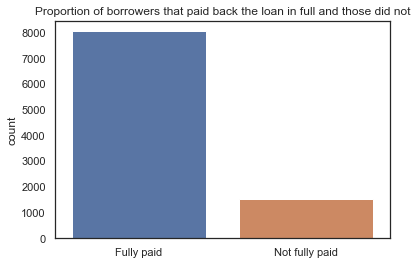

In [257]:
# Proportion of borrowers that paid back the loan in full and those did not
sns.countplot(data = data, x = 'not.fully.paid')
plt.xlabel('')
plt.title('Proportion of borrowers that paid back the loan in full and those did not')
plt.xticks([0,1],['Fully paid', 'Not fully paid'])
plt.show()

In [258]:
print('A larger proportion of borrowers paid back the loan in full.')
print('%.0f (%.2f%%) borrowers are not fully paid.'%(data['not.fully.paid'].sum(), data['not.fully.paid'].mean()*100))
print('%.0f (%.2f%%) borrowers are fully paid.'%((len(data) - data['not.fully.paid'].sum()), (1 - data['not.fully.paid'].mean())*100))

A larger proportion of borrowers paid back the loan in full.
1533 (16.01%) borrowers are not fully paid.
8045 (83.99%) borrowers are fully paid.


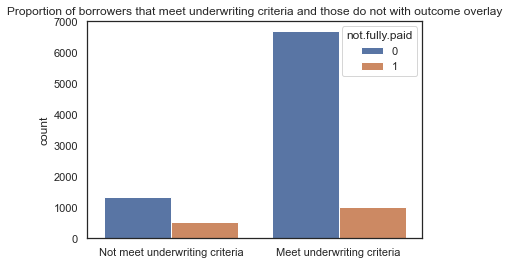

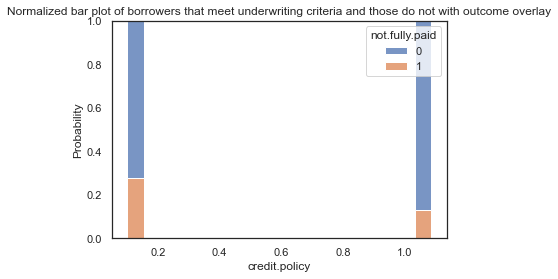

In [259]:
# View distribution of borrowers that meet underwriting criteria and those do not with outcome overlay
sns.countplot(data=data, x='credit.policy', hue='not.fully.paid')       
plt.xlabel('')
plt.xticks([0,1],['Not meet underwriting criteria','Meet underwriting criteria'])
plt.title('Proportion of borrowers that meet underwriting criteria and those do not with outcome overlay')
plt.show()

# View normalized bar plot of borrowers that meet underwriting criteria and those do not with outcome overlay
sns.histplot(data, x='credit.policy', hue='not.fully.paid', stat="probability", multiple="fill", shrink=.8)
plt.title('Normalized bar plot of borrowers that meet underwriting criteria and those do not with outcome overlay')
plt.show()

A larger proportion of borrowers who meets the credit underwriting criteria of LendingClub.com paid back the loan in full.

In [260]:
# View the variables in purpose
data.purpose.unique()

array(['debt_consolidation', 'credit_card', 'all_other',
       'home_improvement', 'small_business', 'major_purchase',
       'educational'], dtype=object)

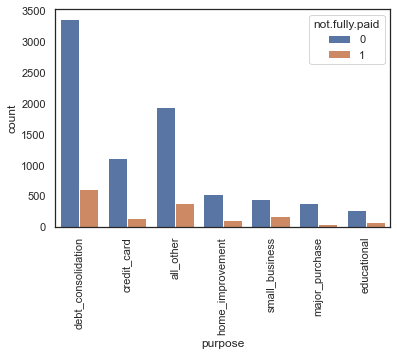

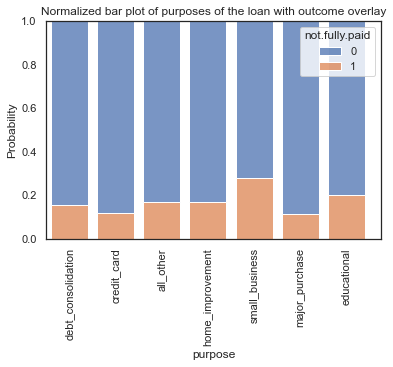

In [261]:
# View distribution of purposes of the loan with outcome overlay
sns.countplot(data=data, x='purpose', hue='not.fully.paid')   
plt.xticks(rotation=90)
plt.show()

# View normalized bar plot of the purposes of the loan with outcome overlay
sns.histplot(data, x='purpose', hue='not.fully.paid', stat="probability", multiple="fill", shrink=.8)
plt.title('Normalized bar plot of purposes of the loan with outcome overlay')
plt.xticks(rotation=90)
plt.show()

Small business and educational have lowest proportions of fully paid borrowers.

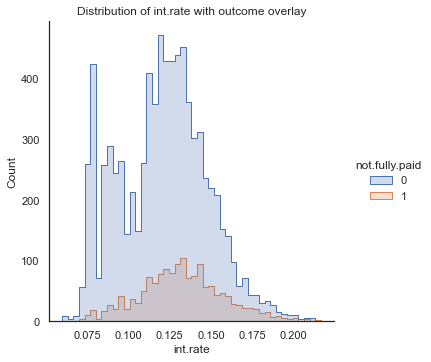

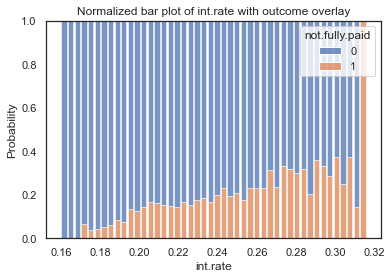

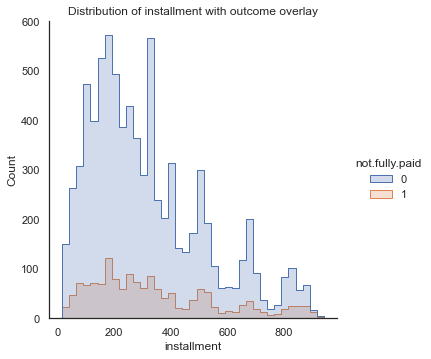

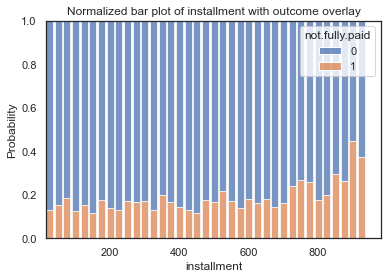

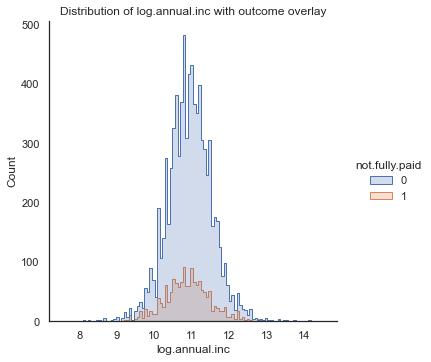

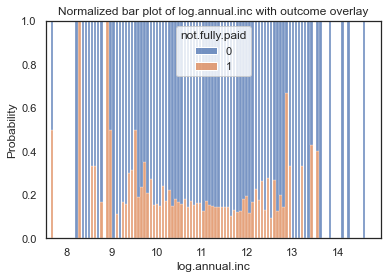

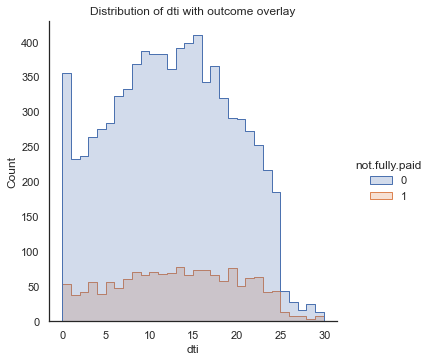

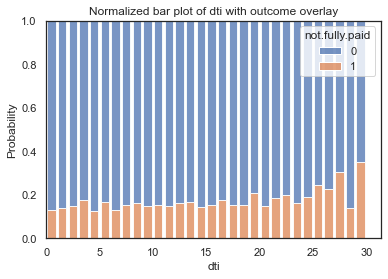

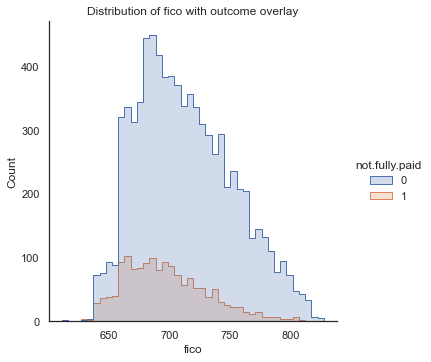

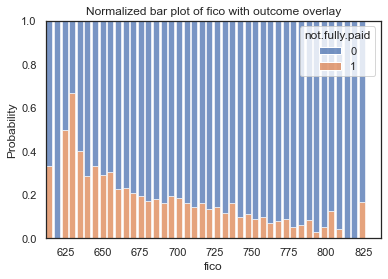

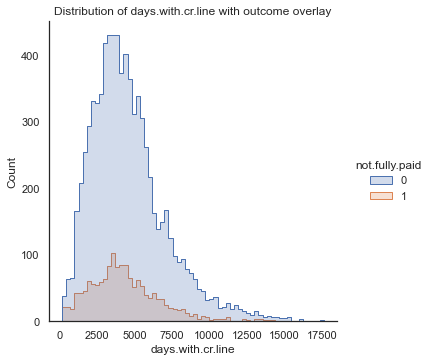

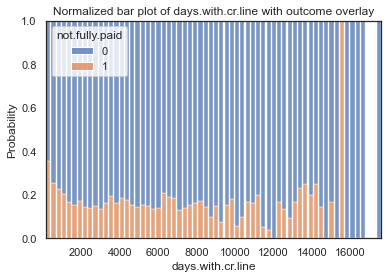

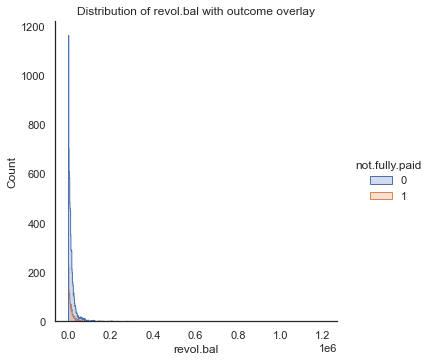

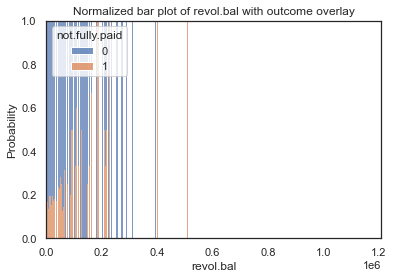

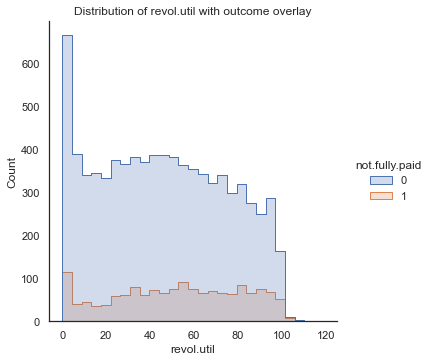

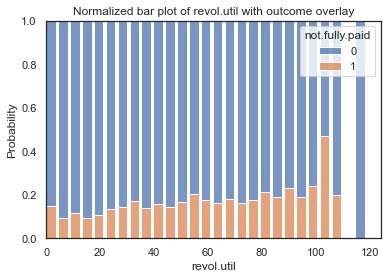

In [262]:
# Visualize the distribution and normalized bar plot for each numeric feature with outcome overlay
for column in ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line','revol.bal','revol.util', ]:
        sns.displot(data, x=column, hue='not.fully.paid', element='step')
        plt.title('Distribution of %s with outcome overlay'%column)
        plt.show()
        sns.histplot(data, x=column, hue='not.fully.paid', stat="probability", multiple="fill", shrink=.8)
        plt.title('Normalized bar plot of %s with outcome overlay'%column)
        plt.show()
plt.show()

The proportion of fully paid borrowers appeared higher when interest rate is lower, when monthly installments owed by the borrower is lower, when debt-to-income ratio of borrower is lower, or when the FICO credit score of borrower is higher. The proportion did not appear to vary with natural log of self-reported income of borrower, number of days the borrower has a credit line, the borrower's revolving balance, or the borrower's revolving line utilization rate. 

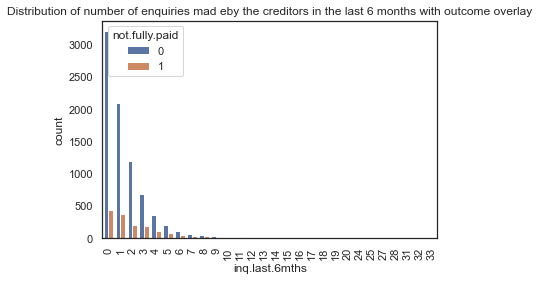

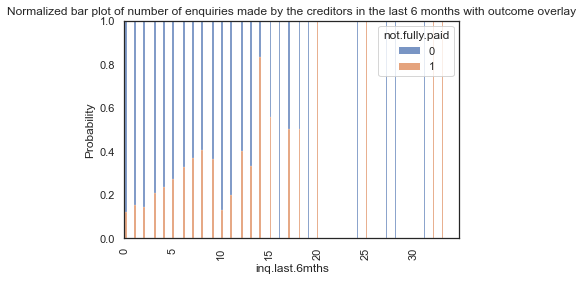

In [263]:
# View distribution of number of enquiries mad eby the creditors in the last 6 months with outcome overlay
sns.countplot(data=data, x='inq.last.6mths', hue='not.fully.paid')   
plt.xticks(rotation=90)
plt.title('Distribution of number of enquiries mad eby the creditors in the last 6 months with outcome overlay')
plt.show()

# View normalized bar plot of the number of enquiries made by the creditors in the last 6 months with outcome overlay
sns.histplot(data, x='inq.last.6mths', hue='not.fully.paid', stat="probability", multiple="fill", shrink=.8)
plt.title('Normalized bar plot of number of enquiries made by the creditors in the last 6 months with outcome overlay')
plt.xticks(rotation=90)
plt.show()

The proportion of fully paid borrowers is lower when a larger number of inquires were made by the creditors in the last 6 months. 

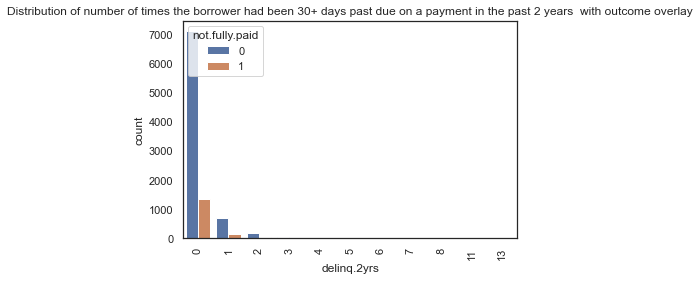

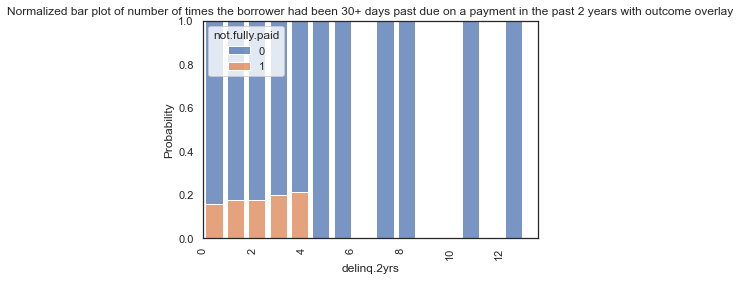

In [264]:
# View distribution of number of times the borrower had been 30+ days past due on a payment in the past 2 years with outcome overlay.
sns.countplot(data=data, x='delinq.2yrs', hue='not.fully.paid')   
plt.xticks(rotation=90)
plt.title('Distribution of number of times the borrower had been 30+ days past due on a payment in the past 2 years  with outcome overlay')
plt.show()

# View normalized bar plot of the number of times the borrower had been 30+ days past due on a payment in the past 2 years with outcome overlay
sns.histplot(data, x='delinq.2yrs', hue='not.fully.paid', stat="probability", multiple="fill", shrink=.8)
plt.title('Normalized bar plot of number of times the borrower had been 30+ days past due on a payment in the past 2 years with outcome overlay')
plt.xticks(rotation=90)
plt.show()

The proportion of borrowers who have fully paid back reduced to zero when the borrower had been 30+ days past due on a payment more than 4 times in the past 2 years.

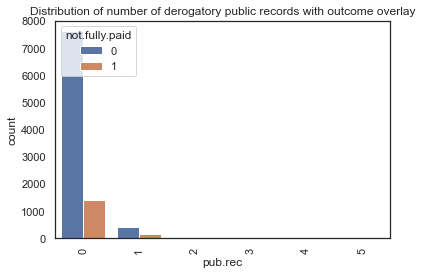

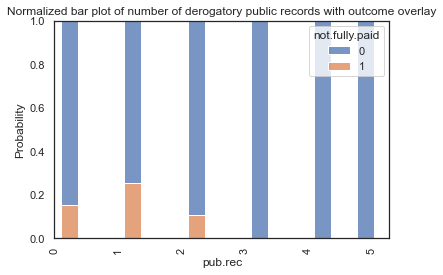

In [265]:
# View distribution of number of derogatory public records with outcome overlay
sns.countplot(data=data, x='pub.rec', hue='not.fully.paid')   
plt.xticks(rotation=90)
plt.title('Distribution of number of derogatory public records with outcome overlay')
plt.show()

# View normalized bar plot of the number of derogatory public records with outcome overlay
sns.histplot(data, x='pub.rec', hue='not.fully.paid', stat="probability", multiple="fill", shrink=.8)
plt.title('Normalized bar plot of number of derogatory public records with outcome overlay')
plt.xticks(rotation=90)
plt.show()


All borrowers with 3 or more derogatory public records have not fully paid back the loan.

### Ccorrelation

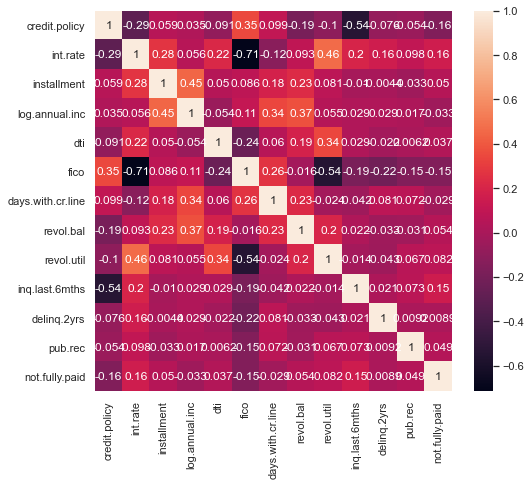

In [266]:
# Visualize correlation between variables
fig = plt.figure(figsize=(8,7))
sns.heatmap(data.corr(),annot=True)
plt.show()

None of the features show high correlation with the outcome (whether or not the borrower pay back in full). Interestingly, there is a strong negative correlation betwen FICO credit score and interest rate.

[]

<Figure size 144x144 with 0 Axes>

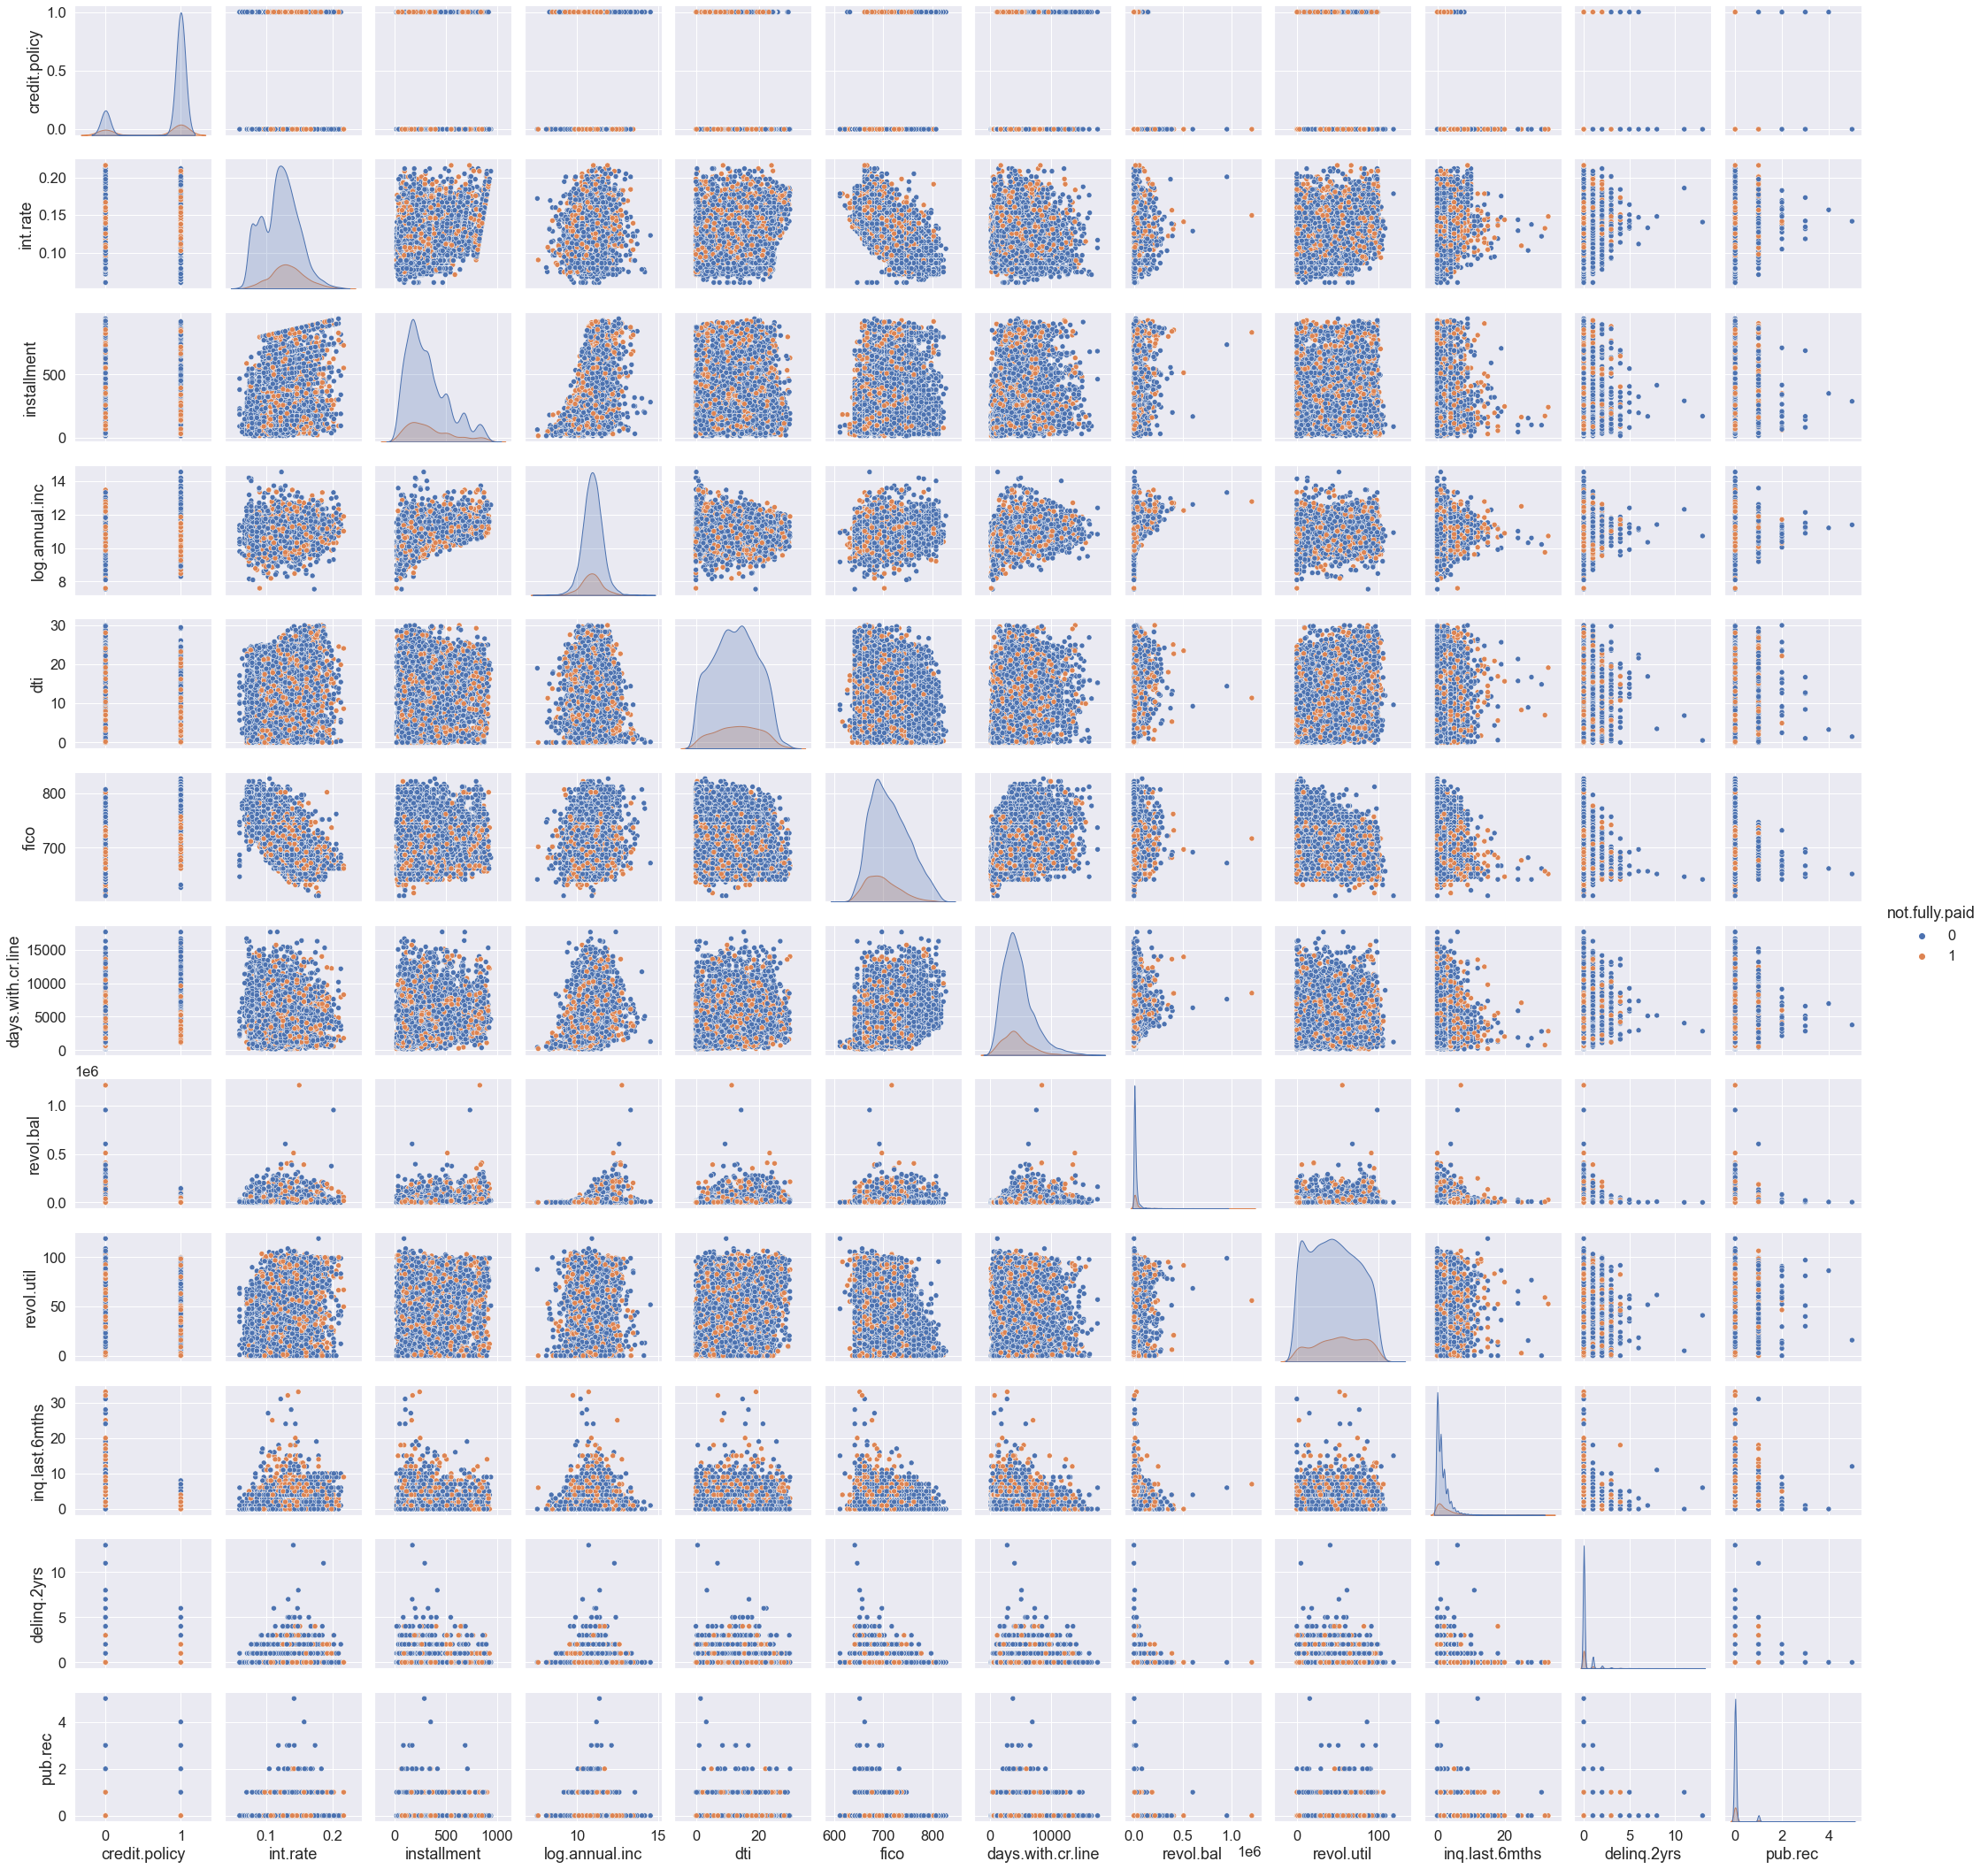

In [267]:
# Visualize the scatterplots for each pair of features with outcome overlay
sns.set(font_scale=1.5)
ax = plt.figure(figsize=(2,2))
sns.pairplot(data, hue='not.fully.paid')
plt.plot()

Two outcomes were not linearly separable, as there was significant overlapping between the two outcomes across all pairs of features.

## Data pre-processing
The following data pre-processing steps were performed.
1. Encoded the categorical variable 'purpose'.
2. Applied log transformation to highly skewed 'revol.bal'.
3. Separated the target 'not.fully.paid' from the features.
4. Split dataset into training and test set in 80:20 ratio using stratified sampling. This provided equal proportions of target classes in training and test sets.
5. Applied Synthetic Minority Over-sampling Technique (SMOTE) on the minority class (borrowers who did not paid back the loan in full) to the training set. This eliminated the bias towards the majority class during model training.
6. Applied standardization to scale each feature to zero mean and unit variance.
7. Converted features to 'float32' and target to 'int64'.

In [349]:
# Encode categorical variable
encoded_data = pd.get_dummies(data, drop_first =True)

In [350]:
# View summary statistics of encoded dataset
encoded_data.describe()

credit.policy     int.rate  installment  log.annual.inc          dti  \
count    9578.000000  9578.000000  9578.000000     9578.000000  9578.000000   
mean        0.804970     0.122640   319.089413       10.932117    12.606679   
std         0.396245     0.026847   207.071301        0.614813     6.883970   
min         0.000000     0.060000    15.670000        7.547502     0.000000   
25%         1.000000     0.103900   163.770000       10.558414     7.212500   
50%         1.000000     0.122100   268.950000       10.928884    12.665000   
75%         1.000000     0.140700   432.762500       11.291293    17.950000   
max         1.000000     0.216400   940.140000       14.528354    29.960000   

              fico  days.with.cr.line     revol.bal   revol.util  \
count  9578.000000        9578.000000  9.578000e+03  9578.000000   
mean    710.846314        4560.767197  1.691396e+04    46.799236   
std      37.970537        2496.930377  3.375619e+04    29.014417   
min     612.000000         178.958333  0.000000e+00     0.000000   
25%     682.000000        2820.000000  3.187000e+03    22.600000   
50%     707.000000        4139.958333  8.596000e+03    46.300000   
75%     737.000000        5730.000000  1.824950e+04    70.900000   
max     827.000000       17639.958330  1.207359e+06   119.000000   

       inq.last.6mths  delinq.2yrs      pub.rec  not.fully.paid  \
count     9578.000000  9578.000000  9578.000000     9578.000000   
mean         1.577469     0.163708     0.062122        0.160054   
std          2.200245     0.546215     0.262126        0.366676   
min          0.000000     0.000000     0.000000        0.000000   
25%          0.000000     0.000000     0.000000        0.000000   
50%          1.000000     0.000000     0.000000        0.000000   
75%          2.000000     0.000000     0.000000        0.000000   
max         33.000000    13.000000     5.000000        1.000000   

       purpose_credit_card  purpose_debt_consolidation  purpose_educational  \
count          9578.000000                 9578.000000          9578.000000   
mean              0.131760                    0.413134             0.035811   
std               0.338248                    0.492422             0.185829   
min               0.000000                    0.000000             0.000000   
25%               0.000000                    0.000000             0.000000   
50%               0.000000                    0.000000             0.000000   
75%               0.000000                    1.000000             0.000000   
max               1.000000                    1.000000             1.000000   

       purpose_home_improvement  purpose_major_purchase  \
count               9578.000000             9578.000000   
mean                   0.065671                0.045625   
std                    0.247720                0.208682   
min                    0.000000                0.000000   
25%                    0.000000                0.000000   
50%                    0.000000                0.000000   
75%                    0.000000                0.000000   
max                    1.000000                1.000000   

       purpose_small_business  
count             9578.000000  
mean                 0.064627  
std                  0.245880  
min                  0.000000  
25%                  0.000000  
50%                  0.000000  
75%                  0.000000  
max                  1.000000

In [351]:
# Determine skewness
encoded_data.skew()

credit.policy                 -1.539621
int.rate                       0.164420
installment                    0.912522
log.annual.inc                 0.028668
dti                            0.023941
fico                           0.471260
days.with.cr.line              1.155748
revol.bal                     11.161058
revol.util                     0.059985
inq.last.6mths                 3.584151
delinq.2yrs                    6.061793
pub.rec                        5.126434
not.fully.paid                 1.854592
purpose_credit_card            2.177793
purpose_debt_consolidation     0.352884
purpose_educational            4.996915
purpose_home_improvement       3.507347
purpose_major_purchase         4.355613
purpose_small_business         3.542085
dtype: float64

In [352]:
# Apply log transformation to highly skewed revol.bal. 
encoded_data['log.revol.bal'] = np.log(encoded_data['revol.bal']+0.000001)
encoded_data.drop('revol.bal', axis=1, inplace=True)

In [353]:
encoded_data.skew()

credit.policy                -1.539621
int.rate                      0.164420
installment                   0.912522
log.annual.inc                0.028668
dti                           0.023941
fico                          0.471260
days.with.cr.line             1.155748
revol.util                    0.059985
inq.last.6mths                3.584151
delinq.2yrs                   6.061793
pub.rec                       5.126434
not.fully.paid                1.854592
purpose_credit_card           2.177793
purpose_debt_consolidation    0.352884
purpose_educational           4.996915
purpose_home_improvement      3.507347
purpose_major_purchase        4.355613
purpose_small_business        3.542085
log.revol.bal                -4.300132
dtype: float64

In [354]:
# Split dataset into predictors and target variables
X = encoded_data.drop('not.fully.paid', axis=1)
y = encoded_data.loc[:,'not.fully.paid'].values
print(X.shape)
print(y.shape)

(9578, 18)
(9578,)


In [355]:
# Split dataset into training and test sets in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7662, 18)
(7662,)
(1916, 18)
(1916,)


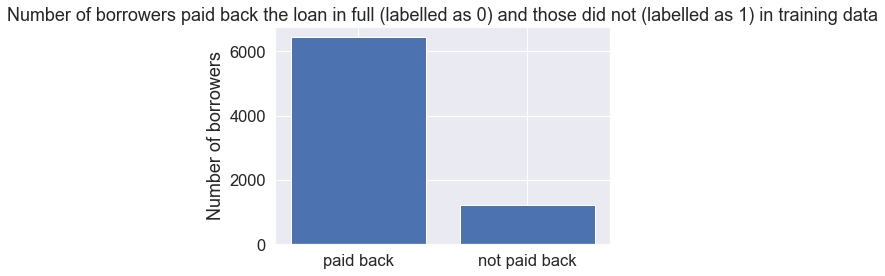

In [356]:
# Visualize the number of borrowers in the two target classes in the training set
train_class_count = pd.DataFrame(y_train)
plt.bar(range(len(train_class_count.value_counts())), train_class_count.value_counts())
plt.xticks([0,1], ["paid back", "not paid back"])
plt.title("Number of borrowers paid back the loan in full (labelled as 0) and those did not (labelled as 1) in training data")
plt.ylabel("Number of borrowers")
plt.xlabel("")
plt.show()

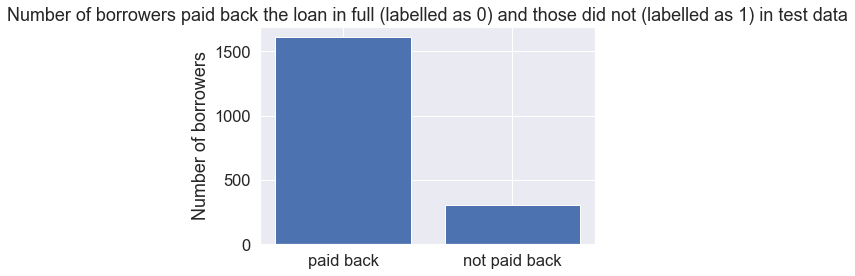

In [357]:
# Visualize the number of borrowers in the two target classes in the test set
test_class_count = pd.DataFrame(y_test)
plt.bar(range(len(test_class_count.value_counts())), test_class_count.value_counts())
plt.xticks([0,1], ["paid back", "not paid back"])
plt.title("Number of borrowers paid back the loan in full (labelled as 0) and those did not (labelled as 1) in test data")
plt.ylabel("Number of borrowers")
plt.xlabel("")
plt.show()

The distribution of borrowers in the two target classes is the same in both training and test sets.

In [358]:
# Apply Data Augmentation by Oversampling Minority Class using Synthetic Minority Over-sampling Technique (SMOTE) to Training Set
smt = SMOTE(sampling_strategy='minority', random_state=1)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(12872, 18)
(12872,)


In [359]:
# Distribution of target classes after resampling in the training set
Counter(y_train_smote)

Counter({0: 6436, 1: 6436})

7167 samples are present in each target class in the training set after resampling.

In [360]:
## Apply standardization to scale each feature to zero mean and unit variance.
scaler = StandardScaler()

In [362]:
# Fit and transform all features in augmented training data 
numeric_cols = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'log.revol.bal','revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec']
X_train_smote[numeric_cols] = scaler.fit_transform(X_train_smote[numeric_cols])
print(X_train_smote.shape)

(12872, 18)


In [363]:
# Transform all features in test data 
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
print(X_test.shape)

(1916, 18)


/Users/bona/Applications/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/bona/Applications/miniconda2/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [364]:
# Inspect distribution of features after scaling
pd.DataFrame(X_train_smote, columns = encoded_data.drop('not.fully.paid', axis=1).columns).describe()

credit.policy      int.rate   installment  log.annual.inc  \
count   12872.000000  1.287200e+04  1.287200e+04    1.287200e+04   
mean        0.665165  1.363456e-16  1.039972e-16   -1.147281e-15   
std         0.471951  1.000039e+00  1.000039e+00    1.000039e+00   
min         0.000000 -2.619586e+00 -1.476228e+00   -5.603787e+00   
25%         0.000000 -6.056334e-01 -7.582811e-01   -5.976292e-01   
50%         1.000000  2.131109e-02 -2.379141e-01    5.725923e-03   
75%         1.000000  6.259558e-01  5.747821e-01    6.032494e-01   
max         1.000000  3.508472e+00  2.940828e+00    6.053691e+00   

                dti          fico  days.with.cr.line    revol.util  \
count  1.287200e+04  1.287200e+04       1.287200e+04  1.287200e+04   
mean   1.754604e-16  2.459361e-16       1.184356e-16  3.131170e-16   
std    1.000039e+00  1.000039e+00       1.000039e+00  1.000039e+00   
min   -1.986080e+00 -2.624328e+00      -1.727396e+00 -1.807242e+00   
25%   -7.553333e-01 -7.845614e-01      -6.821294e-01 -7.958020e-01   
50%    1.923677e-02 -1.901753e-01      -1.656845e-01  3.495150e-02   
75%    7.619860e-01  6.306436e-01       4.588208e-01  8.171532e-01   
max    2.628836e+00  3.461054e+00       4.867288e+00  2.544607e+00   

       inq.last.6mths   delinq.2yrs       pub.rec  purpose_credit_card  \
count    1.287200e+04  1.287200e+04  1.287200e+04         12872.000000   
mean    -1.355780e-15  6.929889e-15  9.520904e-16             0.078776   
std      1.000039e+00  1.000039e+00  1.000039e+00             0.269399   
min     -7.639206e-01 -2.732033e-01 -1.885271e-01             0.000000   
25%     -7.639206e-01 -2.732033e-01 -1.885271e-01             0.000000   
50%     -3.254089e-01 -2.732033e-01 -1.885271e-01             0.000000   
75%      1.131028e-01 -2.732033e-01 -1.885271e-01             0.000000   
max      1.370696e+01  2.388882e+01  2.328073e+01             1.000000   

       purpose_debt_consolidation  purpose_educational  \
count                12872.000000         12872.000000   
mean                     0.317356             0.022141   
std                      0.465465             0.147148   
min                      0.000000             0.000000   
25%                      0.000000             0.000000   
50%                      0.000000             0.000000   
75%                      1.000000             0.000000   
max                      1.000000             1.000000   

       purpose_home_improvement  purpose_major_purchase  \
count              12872.000000            12872.000000   
mean                   0.040631                0.027268   
std                    0.197441                0.162871   
min                    0.000000                0.000000   
25%                    0.000000                0.000000   
50%                    0.000000                0.000000   
75%                    0.000000                0.000000   
max                    1.000000                1.000000   

       purpose_small_business  log.revol.bal  
count            12872.000000   1.287200e+04  
mean                 0.045914   8.254006e-17  
std                  0.209306   1.000039e+00  
min                  0.000000  -5.391989e+00  
25%                  0.000000  -1.922284e-02  
50%                  0.000000   2.102628e-01  
75%                  0.000000   3.902257e-01  
max                  1.000000   1.419392e+00

In [365]:
# Convert features to 'float32' and target to 'int64'
X_train_smote = np.array(X_train_smote).astype('float32')
X_test = np.array(X_test).astype('float32')
y_train_smote = np.array(y_train_smote).astype('int64')
y_test = np.array(y_test).astype('int64')

## Define functions

In [366]:
# Create dictionary for storing mean performance metrics scores
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score),
           'AUC': 'roc_auc'}

In [367]:
# To perform 5-fold cross-validation
def cross_validation(model, scoring):
    cv_results = cross_validate(model, X_train_smote, y_train_smote, cv=5, scoring=scoring)
    return cv_results

In [368]:
# To evaluate models
def models_evaluation(models, scoring):
    all_models_mean = {}
    all_models_std = {}
    for model in models:
        model_mean = []
        model_std = []
        model_results = cross_validation(model, scoring)
        for metric in scoring.keys():
            test_metric = 'test_' + metric
            model_mean.append(model_results[test_metric].mean())
            model_std.append(model_results[test_metric].std())
        all_models_mean[model] = model_mean
        all_models_std[model] = model_std
    all_models_mean = pd.DataFrame(all_models_mean, index = list(scoring.keys()))
    all_models_std = pd.DataFrame(all_models_std, index = list(scoring.keys()))
    
    # Add 'Best Score' column to mean score DataFrame
    all_models_mean['Best Score'] = all_models_mean.idxmax(axis=1) 
    
    # Add 'Minimum standard deviation' column to standard deviation DataFrame
    all_models_std['Minimum standard deviation'] = all_models_std.idxmin(axis=1) 
    
    return all_models_mean, all_models_std

In [369]:
# To visualize results with bar graphs
def visualize_results(models, all_models_mean, std_scores_table):
    x_labels = models
    n_bars = len(all_models_mean.iloc[0,:-1])
    xval = np.arange(n_bars)
    ax = plt.figure(figsize = (6,26))
    for k in range(len(all_models_mean)):
        ax = plt.subplot(5,1,k+1)
        for j in xval:
            plt.barh([j], all_models_mean.iloc[k,j], xerr=std_scores_table.iloc[k,j], alpha=0.6, align='center')
        plt.title('%s for models'%all_models_mean.index[k])
        plt.xlabel('')
        ax.set_yticks(xval)
        ax.invert_yaxis()
        ax.set_yticklabels(x_labels)
    plt.show()


## Support Vector Machine (SVM)
In the context of binary classification, Support Vector Machine (SVM) is an algorithm that separates two classes by maximizing the margin between data points and the optimal decision boundary in a feature space. A kernel can be applied to transform input data into a higher dimensional feature space to enable computation of a decision boundary.

Advantages of SVM:
- Yields global and unique solution.
- The computation time and cost are relatively low, as only the examples closest to the decision boundary (support vectors) determine the optimal decision boundary. 

Disadvantages of SVM: 
- Assumes the data is linearly separable, which is not always appropriate. 
- The selection of kernel requires either prior knowledge on the distribution of the data or trial-and-error. Underfitting occurs when the decision boundary does not effectively separate the data points into two classes in the selected transformed space. 
- Any noise near the decision boundary would have a significant impact to the model. Nonetheless, regularization can be incorporated into SVM by separating the two classes with a large margin, enhancing its immunity to noise.

These steps were taken to optimize the SVM model.
1. Compared SVM models with either second or third degree polynomial, radial basis function (RBF) or sigmoid kernel based on stratified 5-fold cross-validation accuracy, recall, precision, F1 score and AUC score. Stratified five-fold cross-validation was used to reduce bias and increase generalizability of the models. 
2. Determined the optimal hyperparameters, kernel, regularization parameter C and gamma using stratified 5-fold cross validated random search based on AUC score.

In [370]:
# Compare SVM models with different kernels
svc_poly2 = SVC(kernel='poly', degree=2, random_state=1)
svc_poly3 = SVC(kernel='poly', degree=3, random_state=1)
svc_rbf = SVC(kernel='rbf', random_state=1)
svc_sigmoid = SVC(kernel='sigmoid', random_state=1)
dummy_model = DummyClassifier(strategy='stratified', random_state=1)

In [371]:
# Create a list of SVM models
models = [svc_poly2, svc_poly3, svc_rbf, svc_sigmoid, dummy_model]

In [372]:
# Obtain the mean and stardard deviation for each classifier on the training set
mean_scores_table, std_scores_table = models_evaluation(models, scoring)

In [373]:
# Display the average cross-validation scores
mean_scores_table

SVC(degree=2, kernel='poly', random_state=1)  \
accuracy                                       0.756537   
precision                                      0.732310   
recall                                         0.783081   
f1_score                                       0.749052   
AUC                                            0.824177   

           SVC(kernel='poly', random_state=1)  SVC(random_state=1)  \
accuracy                             0.761508             0.781631   
precision                            0.739996             0.775432   
recall                               0.783237             0.766611   
f1_score                             0.751900             0.758701   
AUC                                  0.836075             0.858312   

           SVC(kernel='sigmoid', random_state=1)  \
accuracy                                0.585926   
precision                               0.584204   
recall                                  0.582188   
f1_score                                0.581681   
AUC                                     0.606750   

           DummyClassifier(random_state=1, strategy='stratified')  \
accuracy                                            0.499611        
precision                                           0.499598        
recall                                              0.495648        
f1_score                                            0.497602        
AUC                                                 0.499610        

                                   Best Score  
accuracy                  SVC(random_state=1)  
precision                 SVC(random_state=1)  
recall     SVC(kernel='poly', random_state=1)  
f1_score                  SVC(random_state=1)  
AUC                       SVC(random_state=1)

In [374]:
# Display the standard deviations of the cross-validation scores
std_scores_table

SVC(degree=2, kernel='poly', random_state=1)  \
accuracy                                       0.090880   
precision                                      0.057414   
recall                                         0.195847   
f1_score                                       0.134840   
AUC                                            0.111724   

           SVC(kernel='poly', random_state=1)  SVC(random_state=1)  \
accuracy                             0.089106             0.102940   
precision                            0.051238             0.061766   
recall                               0.199500             0.221548   
f1_score                             0.135985             0.162897   
AUC                                  0.103968             0.103260   

           SVC(kernel='sigmoid', random_state=1)  \
accuracy                                0.029040   
precision                               0.024507   
recall                                  0.078738   
f1_score                                0.053840   
AUC                                     0.041193   

           DummyClassifier(random_state=1, strategy='stratified')  \
accuracy                                            0.001427        
precision                                           0.001441        
recall                                              0.006177        
f1_score                                            0.003693        
AUC                                                 0.001426        

                                  Minimum standard deviation  
accuracy   DummyClassifier(random_state=1, strategy='stra...  
precision  DummyClassifier(random_state=1, strategy='stra...  
recall     DummyClassifier(random_state=1, strategy='stra...  
f1_score   DummyClassifier(random_state=1, strategy='stra...  
AUC        DummyClassifier(random_state=1, strategy='stra...

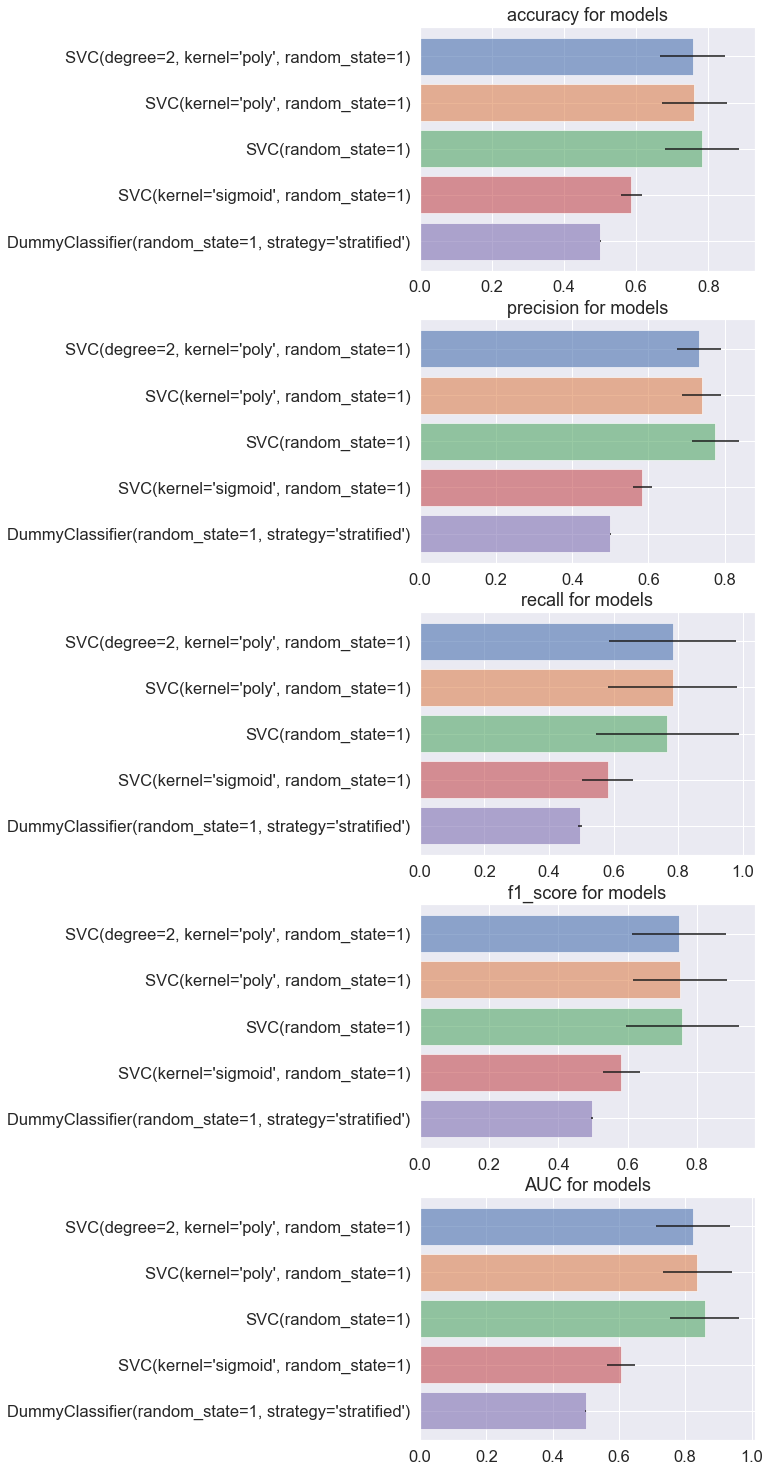

In [375]:
visualize_results(models, mean_scores_table, std_scores_table)

The highest AUC score or accuracy is provided by SVM model with RBF, closely followed by models with third or second degree polynomial kernels. The model with sigmoid kernel yielded lower accuracy or AUC score. The dummy classifier which makes stratified random guesses gave the lowest accuracy or AUC score.

Random search on combinations of the following hyperparameters was performed based on the AUC score.
- kernel: 'rbf', 'poly' (with 'degree' set to 2 or 3 )
- C: four options, 0.1, 1,10 or 100
- gamma (only for 'rbf' kernel): three options, 0.01, 0.02 or 0.03

In [376]:
# Define the search values
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01, 0.02, 0.03],
                     'C': [0.1, 1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [2, 3],
                      'gamma': [0.01, 0.02, 0.03],
                     'C': [0.1, 1, 10, 100]}]

# Print the AUC score for each set of parameters
print("# Tuning hyper-parameters")
classifier = RandomizedSearchCV(SVC(), tuned_parameters, scoring='roc_auc', cv=5, random_state =1)
classifier.fit(X_train_smote, y_train_smote)

print("Best parameters found:")
print()
print(classifier.best_params_)
print()
print("Randomized search scores on training set:")
print()
means = classifier.cv_results_['mean_test_score']
stds = classifier.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, classifier.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))


# Tuning hyper-parameters
Best parameters found:

{'kernel': 'rbf', 'gamma': 0.01, 'C': 1}

Randomized search scores on training set:

0.826 (+/-0.226) for {'kernel': 'poly', 'gamma': 0.01, 'degree': 2, 'C': 100}
0.837 (+/-0.208) for {'kernel': 'poly', 'gamma': 0.02, 'degree': 3, 'C': 100}
0.818 (+/-0.199) for {'kernel': 'poly', 'gamma': 0.02, 'degree': 3, 'C': 10}
0.838 (+/-0.232) for {'kernel': 'rbf', 'gamma': 0.01, 'C': 1}
0.788 (+/-0.174) for {'kernel': 'poly', 'gamma': 0.02, 'degree': 2, 'C': 1}
0.733 (+/-0.135) for {'kernel': 'poly', 'gamma': 0.03, 'degree': 3, 'C': 0.1}
0.705 (+/-0.109) for {'kernel': 'poly', 'gamma': 0.01, 'degree': 3, 'C': 1}
0.795 (+/-0.182) for {'kernel': 'poly', 'gamma': 0.03, 'degree': 3, 'C': 1}
0.832 (+/-0.207) for {'kernel': 'poly', 'gamma': 0.03, 'degree': 3, 'C': 10}
0.825 (+/-0.225) for {'kernel': 'poly', 'gamma': 0.03, 'degree': 2, 'C': 10}


The optimal combination of hyperparameters found for SVM model is RBF kernal, gamma = 0.01 and C=1. The AUC score was 0.838.

In [337]:
# Train best SVM model
best_svm = SVC(kernel='rbf', gamma= 0.01, C= 1, probability= True, random_state=1)
best_svm.fit(X_train_smote, y_train_smote)

SVC(C=1, gamma=0.01, probability=True, random_state=1)

## Multilayer Perceptron (MLP)
MLP is a class of feed-forward artificial neural network consisting of fully connected neurons in an input layer, one or more hidden layers and an output layer. During training, data are repeatedly passed into MLP and each neuron passes to the next layer a signal that is a function of sum of the inputs. An error signal which is calculated by the difference between the actual and the predicted output is back propagated through the network such that the weight of each neuron can be adjusted to minimize the error (loss).

Advantages of MLP:
- Works on non-linearly separable data.
- Does not require prior knowledge or assumption on the data distribution. 

Disadvantages of MLP: 
- Prone to overfitting. Nonetheless, this may be reduced by the application of dropout, batch normalization and early stopping. 
- Technically challenging, computationally expensive and time-consuming to build and train MLP models. Variations in architecture, activation function, learning rate, dropout rate, batch size and other parameters can produce significant difference in predictive power. 
- May yield a solution that is a local minimum instead of the global minimum, depending on the choice of initial weights, learning rate and momentum.

The optimal MLP model contained 6 input neurons, one or two hidden layers and two output neurons. Rectified linear unit (RELu) activation function was applied in the input and hidden layers. Softmax was used in the output layer to give predicted probabilities for each class. Stochastic gradient decent algorithm was used to update the weights of neurons. Early Stopping was applied to reduce overfitting such that the training stopped when there was no improvement in validation accuracy (determined using a random selection of 20% of the training data that was unseen during training) in the last 5 epochs or when a maximum of 100 epochs were completed.

These steps were taken to optimize the MLP model.
1. Compared the performances of stratified 5-fold cross-validated wide, deep and intermediate network architectures were compared in terms of accuracy, precision, recall, F1 score and AUC score. Wide neural network had only one hidden layer containing 9 neurons. Deep neural network had four hidden layers each containing 4 neurons. Intermediate neural network had three hidden layers each containing 6 neurons. Stratified five-fold cross-validation was used to reduce bias and increase generalizability of the models. 
2. Compared wide and intermediate networks with either 3, 6, 9 or 12 hidden layer neurons.
3. Determined the optimal combination of number of hidden layer neurons, optimizer momentum, learning rate, dropout rate and batch size for wide and intermediate networks using stratified 5-fold cross-validated random search based on AUC score.

In [383]:
# Define a wide neural network that has only one hidden layer

# Set number of neurons in hidden layer equal to 9
hidden_size = 9

class WideNetModule(nn.Module):
    def __init__(
            self,
            hidden_dim=hidden_size,
            dropout=0.2):  # Apply mild dropout for regularization
        super(WideNetModule, self).__init__()
        self.dropout = nn.Dropout(dropout) #  Number of input neurons equals the number of features in dataset
        self.hidden = nn.Linear(X.shape[1], hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)  # Number of output neurons is two, because there are two target classes

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X), dim=-1)
        return X

In [384]:
# Define a deep neural network that has four hidden layers

# Set number of neurons in each hidden layer equal to 4
hidden_size1 = 4
hidden_size2 = 4
hidden_size3 = 4 
hidden_size4 = 4 

class DeepNetModule(nn.Module):
    def __init__(
            self,
            hidden_dim1=hidden_size1,
            hidden_dim2=hidden_size2,
            hidden_dim3=hidden_size3,
            hidden_dim4=hidden_size4,
            dropout=0.2): # Apply mild dropout for regularization
        super(DeepNetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden1 = nn.Linear(X.shape[1], hidden_dim1) # Number of input neurons equals the number of features in dataset
        self.hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.hidden3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.hidden4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.output = nn.Linear(hidden_dim4, 2) # Number of output neurons is two, because there are two target classes

    def forward(self, X, **kwargs):
        X = torch.relu(self.hidden1(X))
        X = self.dropout(X)
        X = torch.relu(self.hidden2(X))
        X = self.dropout(X)
        X = torch.relu(self.hidden3(X))
        X = self.dropout(X)
        X = torch.relu(self.hidden4(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X), dim=-1)
        return X

In [385]:
# Define an intermediate network that has two hidden layers

# Set the number of neurons in each hidden layer equal to 6
hidden_size1 = 6
hidden_size2 = 6

class IntermediateNetModule(nn.Module):
    def __init__(
            self,
            hidden_dim1=hidden_size1,
            hidden_dim2=hidden_size2, 
            dropout=0.2 # Apply mild dropout for regularization
    ):
        super(IntermediateNetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden1 = nn.Linear(X.shape[1], hidden_dim1) # Number of input neurons equals the number of features in dataset
        self.hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.output = nn.Linear(hidden_dim2, 2) # Number of output neurons is two, because there are two target classes

    def forward(self, X, **kwargs):
        X = torch.relu(self.hidden1(X))
        X = self.dropout(X)
        X = torch.relu(self.hidden2(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X), dim=-1)
        return X



In [386]:
# Specify parameters for each neural network

# For reproducibility
torch.manual_seed(0)

wideNet = NeuralNetClassifier(module=WideNetModule, 
                                    lr = 0.1, # Learning rate set to 0.1
                                    max_epochs=100, # Maximum epochs set to 100
                                    callbacks=[EarlyStopping()], # Apply early stopping to avoid overfitting
                                    device='cpu', # Set device to 'cpu'
                                    iterator_train__shuffle=True, # Shuffle training data on each epoch
                                    optimizer = torch.optim.SGD, # Use stochastic gradient descent algorithm
                                    batch_size = 32) # Batch size set to 32
                                
deepNet = NeuralNetClassifier(module=DeepNetModule,
                                    lr = 0.1, # Learning rate set to 0.1
                                    max_epochs=100, # Maximum epochs set to 100
                                    callbacks=[EarlyStopping()], # Apply early stopping to avoid overfitting
                                    device='cpu', # Set device to 'cpu'
                                    iterator_train__shuffle=True, # Shuffle training data on each epoch
                                    optimizer = torch.optim.SGD, # Use stochastic gradient descent algorithm
                                    batch_size = 32) # Batch size set to 32
                                   
intermediateNet = NeuralNetClassifier(module=IntermediateNetModule,
                                    lr = 0.1, # Learning rate set to 0.1
                                    max_epochs=100, # Maximum epochs set to 100
                                    callbacks=[EarlyStopping()], # Apply early stopping to avoid overfitting
                                    device='cpu', # Set device to 'cpu'
                                    iterator_train__shuffle=True, # Shuffle training data on each epoch
                                    optimizer = torch.optim.SGD, # Use stochastic gradient descent algorithm
                                    batch_size = 32) # Batch size set to 32
                                

In [387]:
# Create a list of MLP models
models = [wideNet, deepNet, intermediateNet, dummy_model]

In [388]:
# Obtain the mean and stardard deviation for each classifier on the training set
mean_scores_table, std_scores_table = models_evaluation(models, scoring)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6120       0.7612        0.5204  0.3669
      2        0.5103       0.7961        0.4578  0.2968
      3        0.4656       0.8063        0.4329  0.2854
      4        0.4493       0.8087        0.4267  0.2697
      5        0.4407       0.7995        0.4255  0.2734
      6        0.4344       0.8087        0.4265  0.2605
      7        0.4291       0.8092        0.4205  0.2582
      8        0.4303       0.8073        0.4206  0.2593
      9        0.4265       0.8136        0.4172  0.2569
     10        0.4272       0.8121        0.4257  0.2709
     11        0.4261       0.8131        0.4162  0.2559
     12        0.4233       0.8024        0.4210  0.2559
     13        0.4183       0.8029        0.4152  0.2560
     14        0.4205       0.8107        0.4156  0.2557
     15        0.4221       0.8150        0.4130  0.2568
     16        0.4135       0.8

      8        0.6889       0.5408        0.6864  0.3686
      9        0.6860       0.6000        0.6775  0.3664
     10        0.6777       0.5947        0.6747  0.3665
     11        0.6711       0.5757        0.6774  0.3665
     12        0.6630       0.5592        0.6872  0.3661
     13        0.6625       0.5835        0.6779  0.3652
     14        0.6538       0.5646        0.6916  0.3650
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6737       0.7131        0.6115  0.2859
      2        0.5712       0.7898        0.4833  0.2885
      3        0.5192       0.8010        0.4647  0.2894
      4        0.5083       0.8049        0.4515  0.2874
      5        0.5018       0.7864        0.4737  0.2880
      6        0.4971       0.7956        0.4526  0.2891
      7        0.4952       0.8053        0.4534  0.2873
      8        0.4887  

In [389]:
# Display the mean cross-validation scores 
mean_scores_table

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.WideNetModule'>,\n)  \
accuracy                                            0.764462                                                                
precision                                           0.763185                                                                
recall                                              0.738173                                                                
f1_score                                            0.735154                                                                
AUC                                                 0.837675                                                                

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.DeepNetModule'>,\n)  \
accuracy                                            0.675504                                                                
precision                                           0.682785                                                                
recall                                              0.866563                                                                
f1_score                                            0.739122                                                                
AUC                                                 0.714934                                                                

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.IntermediateNetModule'>,\n)  \
accuracy                                            0.754672                                                                        
precision                                           0.755373                                                                        
recall                                              0.724496                                                                        
f1_score                                            0.725173                                                                        
AUC                                                 0.831120                                                                        

           DummyClassifier(random_state=1, strategy='stratified')  \
accuracy                                            0.499611        
precision                                           0.499598        
recall                                              0.495648        
f1_score                                            0.497602        
AUC                                                 0.499610        

                                                  Best Score  
accuracy   <class 'skorch.classifier.NeuralNetClassifier'...  
precision  <class 'skorch.classifier.NeuralNetClassifier'...  
recall     <class 'skorch.classifier.NeuralNetClassifier'...  
f1_score   <class 'skorch.classifier.NeuralNetClassifier'...  
AUC        <class 'skorch.classifier.NeuralNetClassifier'...

In [390]:
# Display the standard deviations of the cross-validation scores
std_scores_table

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.WideNetModule'>,\n)  \
accuracy                                            0.101002                                                                
precision                                           0.059798                                                                
recall                                              0.230067                                                                
f1_score                                            0.173263                                                                
AUC                                                 0.112421                                                                

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.DeepNetModule'>,\n)  \
accuracy                                            0.144005                                                                
precision                                           0.150529                                                                
recall                                              0.124681                                                                
f1_score                                            0.064157                                                                
AUC                                                 0.188671                                                                

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.IntermediateNetModule'>,\n)  \
accuracy                                            0.098495                                                                        
precision                                           0.062765                                                                        
recall                                              0.223819                                                                        
f1_score                                            0.169557                                                                        
AUC                                                 0.104050                                                                        

           DummyClassifier(random_state=1, strategy='stratified')  \
accuracy                                            0.001427        
precision                                           0.001441        
recall                                              0.006177        
f1_score                                            0.003693        
AUC                                                 0.001426        

                                  Minimum standard deviation  
accuracy   DummyClassifier(random_state=1, strategy='stra...  
precision  DummyClassifier(random_state=1, strategy='stra...  
recall     DummyClassifier(random_state=1, strategy='stra...  
f1_score   DummyClassifier(random_state=1, strategy='stra...  
AUC        DummyClassifier(random_state=1, strategy='stra...

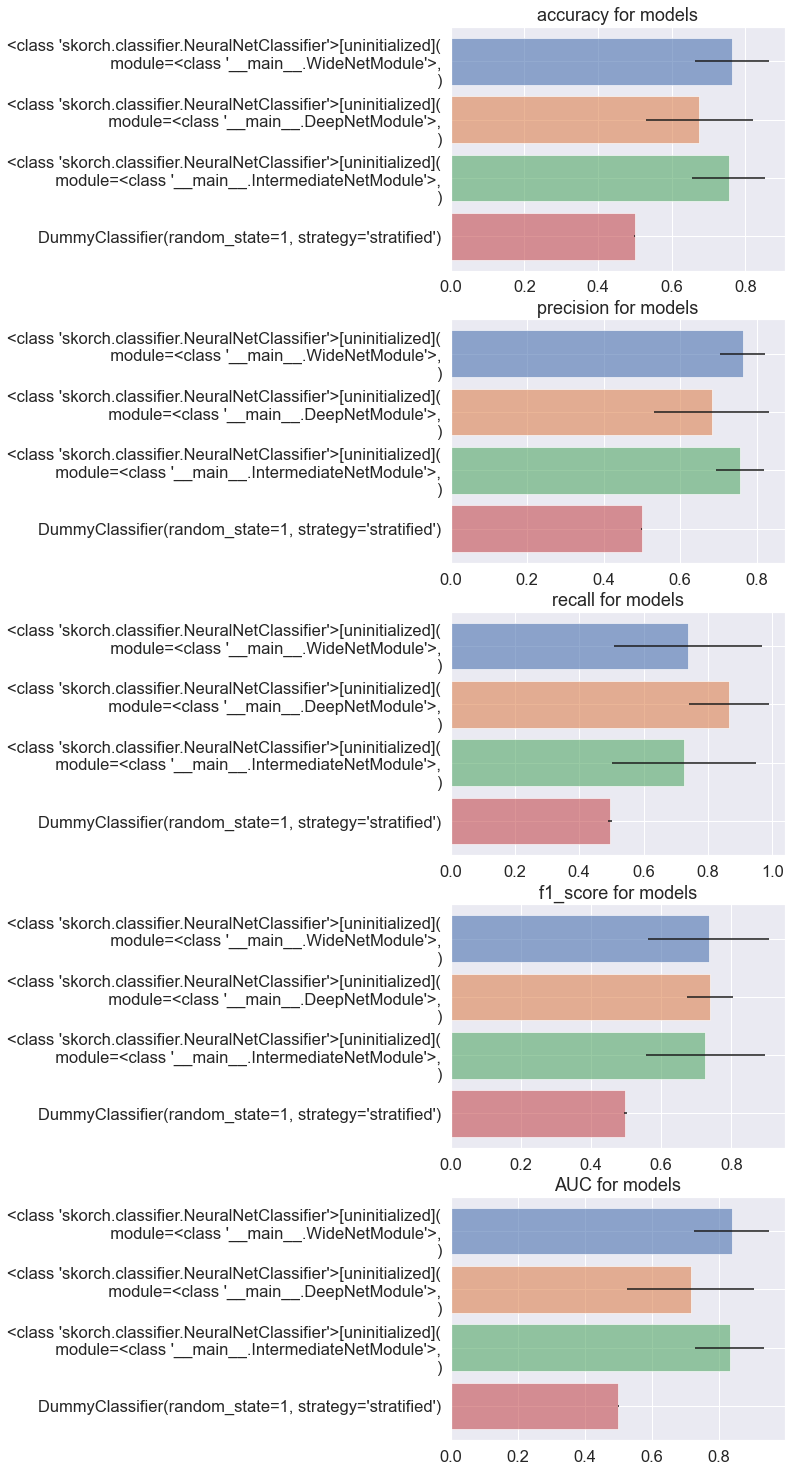

In [391]:
visualize_results(models, mean_scores_table, std_scores_table)

MLP models with wide or intermediate architecture provided the highest accuracy or AUC score.

We will now compare MLP wide or intermediate networks containing either 3, 6, 9 or 12 hidden layer neurons.

In [392]:
# Define a neural network that has only one hidden layer 

# Set number of neurons in the hidden layer equal to 3
hidden_size = 3

class Wide3NetModule(nn.Module):
    def __init__(
            self,
            hidden_dim=hidden_size,
            dropout = 0.2 # Apply mild dropout for regularization
    ):
        super(Wide3NetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(X.shape[1], hidden_size)
        self.output = nn.Linear(hidden_size, 2)

    def forward(self, X, **kwargs):
        X = torch.relu(self.hidden(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X),dim=-1)
        return X

In [393]:
# Define a neural network that has only one hidden layer 

# Set number of neurons in the hidden layer equal to 6
hidden_size = 6

class Wide6NetModule(nn.Module):
    def __init__(
            self,
            hidden_dim=hidden_size,
            dropout = 0.2 # Apply mild dropout for regularization
    ):
        super(Wide6NetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(X.shape[1], hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, X, **kwargs):
        X = torch.relu(self.hidden(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X),dim=-1)
        return X

In [394]:
# Define a neural network that has only one hidden layer

# Set number of neurons in the hidden layer equal to 9
hidden_size = 9

class Wide9NetModule(nn.Module):
    def __init__(
            self,
            hidden_dim=hidden_size,
            dropout = 0.2 # Apply mild dropout for regularization
    ):
        super(Wide9NetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(X.shape[1], hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, X, **kwargs):
        X = torch.relu(self.hidden(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X),dim=-1)
        return X

In [395]:
# Define a neural network that has only one hidden layer 

# Set number of neurons in the hidden layer equal to 12
hidden_size = 12

class Wide12NetModule(nn.Module):
    def __init__(
            self,
            hidden_dim=hidden_size,
            dropout = 0.2 # Apply mild dropout for regularization
    ):
        super(Wide12NetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(X.shape[1], hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, X, **kwargs):
        X = torch.relu(self.hidden(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X),dim=-1)
        return X

In [396]:
# Define a neural network that has only two hidden layers 

# Set number of neurons in each hidden layer equal to 3
hidden_sizeA = 3
hidden_sizeB = 3

class Intermediate3NetModule(nn.Module):
    def __init__(
            self,
            hidden_dimA=hidden_sizeA,
            hidden_dimB=hidden_sizeB,
            dropout = 0.2 # Apply mild dropout for regularization
    ):
        super(Intermediate3NetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hiddenA = nn.Linear(X.shape[1], hidden_sizeA)
        self.hiddenB = nn.Linear(hidden_sizeA, hidden_sizeB)
        self.output = nn.Linear(hidden_sizeB, 2)

    def forward(self, X, **kwargs):
        X = torch.relu(self.hiddenA(X))
        X = self.dropout(X)
        X = torch.relu(self.hiddenB(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X),dim=-1)
        return X

In [397]:
# Define a neural network that has only two hidden layers 

# Set number of neurons in each hidden layer equal to 6
hidden_sizeA = 6
hidden_sizeB = 6

class Intermediate6NetModule(nn.Module):
    def __init__(
            self,
            hidden_dimA=hidden_sizeA,
            hidden_dimB=hidden_sizeB,
            dropout = 0.2 # Apply mild dropout for regularization
    ):
        super(Intermediate6NetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hiddenA = nn.Linear(X.shape[1], hidden_dimA)
        self.hiddenB = nn.Linear(hidden_dimA, hidden_dimB)
        self.output = nn.Linear(hidden_dimB, 2)

    def forward(self, X, **kwargs):
        X = torch.relu(self.hiddenA(X))
        X = self.dropout(X)
        X = torch.relu(self.hiddenB(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X),dim=-1)
        return X

In [398]:
# Define a neural network that has two hidden layers 

# Set number of neurons in each hidden layer equal to 9
hidden_sizeA = 9
hidden_sizeB = 9

class Intermediate9NetModule(nn.Module):
    def __init__(
            self,
            hidden_dimA=hidden_sizeA,
            hidden_dimB=hidden_sizeB,
            dropout=0.2 # Apply mild dropout for regularization
    ):
        super(Intermediate9NetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hiddenA = nn.Linear(X.shape[1], hidden_dimA)
        self.hiddenB = nn.Linear(hidden_dimA, hidden_dimB)
        self.output = nn.Linear(hidden_dimB, 2)

    def forward(self, X, **kwargs):
        X = torch.relu(self.hiddenA(X))
        X = self.dropout(X)
        X = torch.relu(self.hiddenB(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X), dim=-1)
        return X

In [399]:
# Define a neural network that has two hidden layers 

# Set number of neurons in each hidden layer equal to 12
hidden_sizeA = 12
hidden_sizeB = 12

class Intermediate12NetModule(nn.Module):
    def __init__(
            self,
            hidden_dimA=hidden_sizeA,
            hidden_dimB=hidden_sizeB,
            dropout=0.2 # Apply mild dropout for regularization
    ):
        super(Intermediate12NetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hiddenA = nn.Linear(X.shape[1], hidden_dimA)
        self.hiddenB = nn.Linear(hidden_dimA, hidden_dimB)
        self.output = nn.Linear(hidden_dimB, 2)

    def forward(self, X, **kwargs):
        X = torch.relu(self.hiddenA(X))
        X = self.dropout(X)
        X = torch.relu(self.hiddenB(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X),dim=-1)
        return X


In [400]:
# Specify parameters for each neural network

# For reproducibility
torch.manual_seed(0)

wide3Net = NeuralNetClassifier(module=Wide3NetModule,
                                    lr = 0.1, # Learning rate set to 0.1
                                    max_epochs=100, # Maximum epochs set to 100
                                    callbacks=[EarlyStopping()], # Apply early stopping to avoid overfitting
                                    device='cpu', # Set device to 'cpu'
                                    iterator_train__shuffle=True, # Shuffle training data on each epoch
                                    optimizer = torch.optim.SGD, # Use stochastic gradient descent algorithm
                                    batch_size = 32) # Batch size set to 32
                            
wide6Net = NeuralNetClassifier(module=Wide6NetModule, 
                                    lr = 0.1, # Learning rate set to 0.1
                                    max_epochs=100, # Maximum epochs set to 100
                                    callbacks=[EarlyStopping()], # Apply early stopping to avoid overfitting
                                    device='cpu', # Set device to 'cpu'
                                    iterator_train__shuffle=True, # Shuffle training data on each epoch
                                    optimizer = torch.optim.SGD, # Use stochastic gradient descent algorithm
                                    batch_size = 32) # Batch size set to 32
                                
wide9Net = NeuralNetClassifier(module=Wide9NetModule,
                                    lr = 0.1, # Learning rate set to 0.1
                                    max_epochs=100, # Maximum epochs set to 100
                                    callbacks=[EarlyStopping()], # Apply early stopping to avoid overfitting
                                    device='cpu', # Set device to 'cpu'
                                    iterator_train__shuffle=True, # Shuffle training data on each epoch
                                    optimizer = torch.optim.SGD, # Use stochastic gradient descent algorithm
                                    batch_size = 32) # Batch size set to 32

wide12Net = NeuralNetClassifier(module=Wide12NetModule,
                                    lr = 0.1, # Learning rate set to 0.1
                                    max_epochs=100, # Maximum epochs set to 100
                                    callbacks=[EarlyStopping()], # Apply early stopping to avoid overfitting
                                    device='cpu', # Set device to 'cpu'
                                    iterator_train__shuffle=True, # Shuffle training data on each epoch
                                    optimizer = torch.optim.SGD, # Use stochastic gradient descent algorithm
                                    batch_size = 32) # Batch size set to 32

intermediate3Net = NeuralNetClassifier(module=Intermediate3NetModule, 
                                    lr = 0.1, # Learning rate set to 0.1
                                    max_epochs=100, # Maximum epochs set to 100
                                    callbacks=[EarlyStopping()], # Apply early stopping to avoid overfitting
                                    device='cpu', # Set device to 'cpu'
                                    iterator_train__shuffle=True, # Shuffle training data on each epoch
                                    optimizer = torch.optim.SGD, # Use stochastic gradient descent algorithm
                                    batch_size = 32) # Batch size set to 32

intermediate6Net = NeuralNetClassifier(module=Intermediate6NetModule,
                                    lr = 0.1, # Learning rate set to 0.1
                                    max_epochs=100, # Maximum epochs set to 100
                                    callbacks=[EarlyStopping()], # Apply early stopping to avoid overfitting
                                    device='cpu', # Set device to 'cpu'
                                    iterator_train__shuffle=True, # Shuffle training data on each epoch
                                    optimizer = torch.optim.SGD, # Use stochastic gradient descent algorithm
                                    batch_size = 32) # Batch size set to 32

intermediate9Net = NeuralNetClassifier(module=Intermediate9NetModule,
                                    lr = 0.1, # Learning rate set to 0.1
                                    max_epochs=100, # Maximum epochs set to 100
                                    callbacks=[EarlyStopping()], # Apply early stopping to avoid overfitting
                                    device='cpu', # Set device to 'cpu'
                                    iterator_train__shuffle=True, # Shuffle training data on each epoch
                                    optimizer = torch.optim.SGD, # Use stochastic gradient descent algorithm
                                    batch_size = 32) # Batch size set to 32

intermediate12Net = NeuralNetClassifier(module=Intermediate12NetModule,
                                    lr = 0.1, # Learning rate set to 0.1
                                    max_epochs=100, # Maximum epochs set to 100
                                    callbacks=[EarlyStopping()], # Apply early stopping to avoid overfitting
                                    device='cpu', # Set device to 'cpu'
                                    iterator_train__shuffle=True, # Shuffle training data on each epoch
                                    optimizer = torch.optim.SGD, # Use stochastic gradient descent algorithm
                                    batch_size = 32) # Batch size set to 32


In [401]:
models = [wide3Net, wide6Net, wide9Net, wide12Net, intermediate3Net, intermediate6Net, intermediate9Net, intermediate12Net]

In [402]:
mean_scores_table, std_scores_table = models_evaluation(models, scoring)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6197       0.7364        0.5366  0.2549
      2        0.5125       0.7859        0.4606  0.2611
      3        0.4612       0.7917        0.4432  0.2592
      4        0.4379       0.7893        0.4505  0.2901
      5        0.4331       0.8000        0.4290  0.2682
      6        0.4223       0.8107        0.4191  0.2624
      7        0.4201       0.8078        0.4165  0.2599
      8        0.4179       0.8160        0.4081  0.2587
      9        0.4208       0.8141        0.4146  0.2597
     10        0.4146       0.8058        0.4179  0.2635
     11        0.4147       0.8170        0.4072  0.2589
     12        0.4073       0.8214        0.4027  0.2636
     13        0.4120       0.8233        0.4034  0.2584
     14        0.4080       0.8218        0.4077  0.2617
     15        0.4096       0.8233        0.4011  0.2694
     16        0.4047       0.8

      4        0.4536       0.8078        0.4247  0.2509
      5        0.4390       0.8034        0.4225  0.2511
      6        0.4329       0.8150        0.4122  0.2488
      7        0.4346       0.7893        0.4220  0.2729
      8        0.4270       0.8141        0.4045  0.2496
      9        0.4249       0.8073        0.4145  0.2513
     10        0.4174       0.8150        0.4110  0.2518
     11        0.4170       0.8126        0.4053  0.2513
     12        0.4141       0.8218        0.4049  0.2512
     13        0.4160       0.8184        0.4008  0.2581
     14        0.4128       0.8233        0.4130  0.2524
     15        0.4130       0.8238        0.4013  0.2506
     16        0.4118       0.8199        0.3981  0.2525
     17        0.4101       0.8204        0.4021  0.2513
     18        0.4096       0.8165        0.3988  0.2502
     19        0.4105       0.8218        0.4054  0.2504
     20        0.4072       0.8184        0.3992  0.2518
     21        0.4063       0.8

      3        0.4931       0.7985        0.4381  0.2904
      4        0.4566       0.8141        0.4155  0.2926
      5        0.4477       0.8160        0.4081  0.3124
      6        0.4415       0.8141        0.4128  0.2898
      7        0.4275       0.8097        0.4178  0.2890
      8        0.4262       0.8073        0.4216  0.2898
      9        0.4269       0.8165        0.4105  0.2935
     10        0.4191       0.8189        0.4036  0.2921
     11        0.4156       0.8214        0.4016  0.2899
     12        0.4218       0.8218        0.3988  0.2917
     13        0.4162       0.8146        0.4032  0.2890
     14        0.4120       0.8204        0.4057  0.2956
     15        0.4125       0.8184        0.4035  0.2901
     16        0.4131       0.8233        0.3958  0.2911
     17        0.4113       0.8184        0.4074  0.2916
     18        0.4097       0.8092        0.4042  0.2918
     19        0.4086       0.8136        0.4006  0.3184
     20        0.4100       0.8

     10        0.4324       0.8102        0.4097  0.2911
     11        0.4361       0.8141        0.4123  0.2918
     12        0.4332       0.8102        0.4119  0.2913
     13        0.4270       0.8126        0.4070  0.2900
     14        0.4266       0.8131        0.4054  0.2924
     15        0.4237       0.8053        0.4212  0.2901
     16        0.4265       0.8121        0.4087  0.2867
     17        0.4245       0.8068        0.4121  0.2888
     18        0.4217       0.8136        0.4133  0.2877
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6628       0.5854        0.6778  0.2861
      2        0.5736       0.5573        0.7608  0.2864
      3        0.5221       0.5655        0.7631  0.2893
      4        0.4954       0.5442        0.8001  0.2854
      5        0.4904       0.5757        0.7488  0.2886
Stopping since valid_lo

In [403]:
# Display the mean cross-validation scores 
mean_scores_table

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Wide3NetModule'>,\n)  \
accuracy                                            0.768347                                                                 
precision                                           0.769770                                                                 
recall                                              0.736938                                                                 
f1_score                                            0.739201                                                                 
AUC                                                 0.842382                                                                 

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Wide6NetModule'>,\n)  \
accuracy                                            0.766404                                                                 
precision                                           0.765964                                                                 
recall                                              0.740818                                                                 
f1_score                                            0.744376                                                                 
AUC                                                 0.834820                                                                 

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Wide9NetModule'>,\n)  \
accuracy                                            0.765472                                                                 
precision                                           0.763005                                                                 
recall                                              0.743621                                                                 
f1_score                                            0.742107                                                                 
AUC                                                 0.837779                                                                 

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Wide12NetModule'>,\n)  \
accuracy                                            0.764773                                                                  
precision                                           0.773406                                                                  
recall                                              0.719845                                                                  
f1_score                                            0.734566                                                                  
AUC                                                 0.835641                                                                  

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Intermediate3NetModule'>,\n)  \
accuracy                                            0.766405                                                                         
precision                                           0.760622                                                                         
recall                                              0.745790                                                                         
f1_score                                            0.741592                                                                         
AUC                                                 0.837401                                                                         

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Intermediate6NetModule'>,\n)  \
accuracy                              

In [404]:
# Display the standard deviations of the cross-validation scores
std_scores_table

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Wide3NetModule'>,\n)  \
accuracy                                            0.102983                                                                 
precision                                           0.065936                                                                 
recall                                              0.225814                                                                 
f1_score                                            0.171220                                                                 
AUC                                                 0.109701                                                                 

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Wide6NetModule'>,\n)  \
accuracy                                            0.100906                                                                 
precision                                           0.075760                                                                 
recall                                              0.202441                                                                 
f1_score                                            0.153696                                                                 
AUC                                                 0.116491                                                                 

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Wide9NetModule'>,\n)  \
accuracy                                            0.099021                                                                 
precision                                           0.066571                                                                 
recall                                              0.212224                                                                 
f1_score                                            0.157659                                                                 
AUC                                                 0.116362                                                                 

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Wide12NetModule'>,\n)  \
accuracy                                            0.102497                                                                  
precision                                           0.073684                                                                  
recall                                              0.212607                                                                  
f1_score                                            0.166358                                                                  
AUC                                                 0.114916                                                                  

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Intermediate3NetModule'>,\n)  \
accuracy                                            0.104012                                                                         
precision                                           0.070913                                                                         
recall                                              0.220837                                                                         
f1_score                                            0.166777                                                                         
AUC                                                 0.115126                                                                         

           <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](\n  module=<class '__main__.Intermediate6NetModule'>,\n)  \
accuracy                              

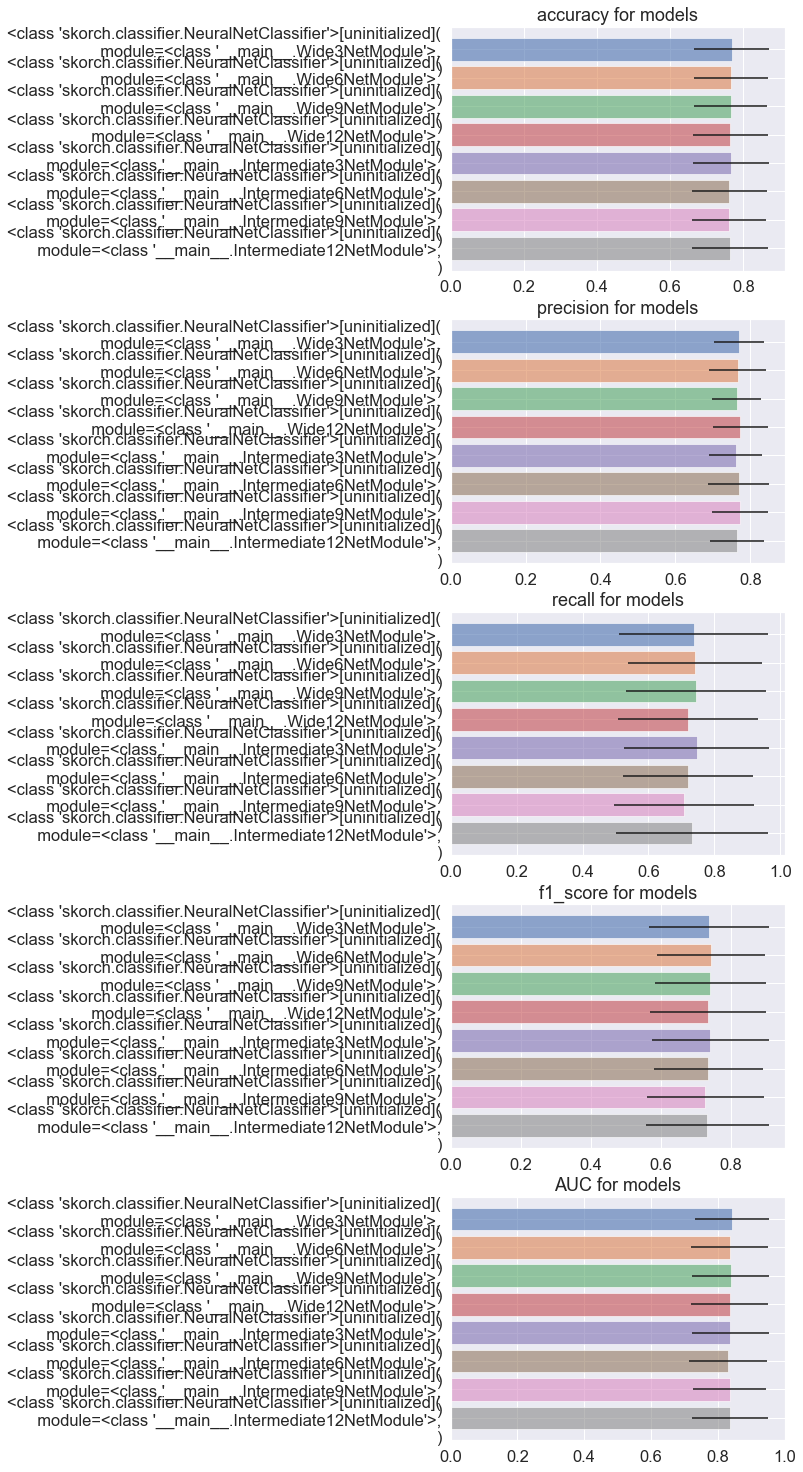

In [405]:
visualize_results(models, mean_scores_table, std_scores_table)

All the networks with either one or two hidden layers and either 3, 6, 9 or 12 hidden layer neurons in each hidden layer displayed similar accuracies or AUC scores. It is better to find the optimal number of neurons along with optimal values of other hyperparameters using random search.

In [406]:
# Define a neural network with a single hidden layer
class NetModule(nn.Module):
    def __init__(
            self,
            num_units=3,
            dropout = 0.5
    ):
        super(NetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(X.shape[1],num_units)
        self.output = nn.Linear(num_units, 2)

    def forward(self, X, **kwargs):
        X = torch.relu(self.hidden(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X),dim=-1)
        return X

In [407]:
# Set the parameters for the neural network

# For reproducibility
torch.manual_seed(0)

searchNet = NeuralNetClassifier(module=NetModule, 
                    max_epochs=100,
                    callbacks=[EarlyStopping()],
                    device='cpu',
                    iterator_train__shuffle=True,# Shuffle training data on each epoch
                    batch_size = 32)

In [408]:
# Perform random search on the neuron network with one hidden layer

# Define the search values of the hyperparameters
tuned_parameters = [{'module__num_units':[3,4,5,6,7,8,9],
                    'optimizer__momentum':[0.1,0.3,0.6,0.9],
                    'lr':[1,0.1,0.01],
                    'module__dropout':[0.1,0.2,0.5],
                    'batch_size':[16,32,64]}]

# Print the AUC score for each set of hyperparameters
print("# Tuning hyper-parameters")
print()
classifier = RandomizedSearchCV(searchNet, tuned_parameters, scoring='roc_auc', cv=5)
classifier.fit(X_train_smote, y_train_smote)

print("Best parameters found:")
print()
print(classifier.best_params_)
print()
print("Randomized search scores on training set:")
print()
means = classifier.cv_results_['mean_test_score']
stds = classifier.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, classifier.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

# Tuning hyper-parameters

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6589       0.6621        0.6115  0.5165
      2        0.5992       0.7170        0.5652  0.4458
      3        0.5549       0.7544        0.5245  0.4619
      4        0.5186       0.7631        0.4931  0.4473
      5        0.4936       0.7806        0.4790  0.4504
      6        0.4757       0.7864        0.4589  0.4715
      7        0.4624       0.7981        0.4502  0.4510
      8        0.4517       0.8005        0.4426  0.4443
      9        0.4446       0.8092        0.4355  0.4461
     10        0.4387       0.8034        0.4315  0.4466
     11        0.4357       0.8015        0.4249  0.4482
     12        0.4318       0.8029        0.4257  0.4469
     13        0.4270       0.8039        0.4209  0.4475
     14        0.4239       0.8058        0.4212  0.4474
     15        0.4266       0.8073        0.4199  0.4464
    

     22        0.4195       0.8175        0.4121  0.4449
     23        0.4166       0.8160        0.4060  0.4404
     24        0.4124       0.8180        0.4065  0.4391
     25        0.4155       0.8150        0.4100  0.4416
     26        0.4152       0.8209        0.4068  0.4372
     27        0.4149       0.8049        0.4102  0.4470
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6678       0.5864        0.6639  0.4376
      2        0.6036       0.5845        0.6714  0.4384
      3        0.5465       0.5835        0.7089  0.4358
      4        0.5178       0.5718        0.7223  0.4609
      5        0.5082       0.5728        0.7350  0.4382
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        

      3        0.6049       0.5840        0.6874  0.2637
      4        0.5815       0.5830        0.6961  0.2640
      5        0.5602       0.5777        0.7091  0.2867
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6762       0.5723        0.6723  0.2631
      2        0.6358       0.5806        0.6678  0.2649
      3        0.6168       0.5854        0.6728  0.2633
      4        0.5920       0.5893        0.6831  0.2648
      5        0.5684       0.5845        0.6950  0.2642
      6        0.5436       0.5850        0.7146  0.2615
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6845       0.5806        0.6793  0.2637
      2        0.6527       0.5816        0.6748  0.2680
      3        

      2        0.6339       0.5874        0.6762  0.2030
      3        0.6054       0.5772        0.6868  0.1749
      4        0.5776       0.5684        0.7104  0.1753
      5        0.5717       0.5660        0.7241  0.1754
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6657       0.5820        0.6823  0.1709
      2        0.6285       0.5796        0.6955  0.1743
      3        0.6015       0.5786        0.6942  0.1760
      4        0.5759       0.5762        0.6936  0.1747
      5        0.5616       0.5830        0.7063  0.1746
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6539       0.5942        0.6627  0.1714
      2        0.6224       0.5845        0.6762  0.1744
      3        

      2        0.5590       0.5680        0.7289  0.2651
      3        0.5371       0.5743        0.7433  0.2638
      4        0.5277       0.5718        0.7454  0.2859
      5        0.5173       0.5544        0.7950  0.2661
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6313       0.5806        0.6988  0.2636
      2        0.5609       0.5675        0.7217  0.2671
      3        0.5361       0.5714        0.7757  0.2762
      4        0.5198       0.5573        0.8150  0.2650
      5        0.5113       0.5515        0.7602  0.2667
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6204       0.5903        0.6804  0.2652
      2        0.5559       0.5597        0.8236  0.2902
      3        

     40        0.5320       0.7990        0.4916  0.1999
     41        0.5393       0.7951        0.4933  0.1755
     42        0.5317       0.8015        0.4895  0.1745
     43        0.5391       0.8019        0.4910  0.1749
     44        0.5389       0.8000        0.4890  0.1756
     45        0.5315       0.8019        0.4864  0.1737
     46        0.5340       0.8034        0.4888  0.1749
     47        0.5333       0.8049        0.4872  0.1754
     48        0.5362       0.7995        0.4874  0.1757
     49        0.5391       0.7976        0.4860  0.1748
     50        0.5305       0.7985        0.4867  0.1755
     51        0.5366       0.8034        0.4842  0.1744
     52        0.5291       0.7985        0.4851  0.1883
     53        0.5293       0.7981        0.4854  0.1746
     54        0.5388       0.7961        0.4861  0.1767
     55        0.5312       0.7981        0.4861  0.1747
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss  

      2        0.6159       0.5801        0.6824  0.2653
      3        0.5790       0.5791        0.7099  0.2652
      4        0.5493       0.5796        0.7220  0.2640
      5        0.5250       0.5816        0.7249  0.2645
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5931       0.5817        0.7505  0.3316
      2        0.4798       0.5643        0.8370  0.3353
      3        0.4470       0.5631        0.9226  0.3380
      4        0.4398       0.5584        0.8950  0.3318
      5        0.4365       0.5740        0.8800  0.3359
Stopping since valid_loss has not improved in the last 5 epochs.
Best parameters found:

{'optimizer__momentum': 0.9, 'module__num_units': 4, 'module__dropout': 0.1, 'lr': 0.01, 'batch_size': 32}

Randomized search scores on training set:

0.814 (+/-0.219) for {'optimizer__momentum': 0.1, 'module__num_units

The best parameters found by random search for MLPs with a single hidden layer were 'optimizer__momentum': 0.9, 'module__num_units': 4, 'module__dropout': 0.1, 'lr': 0.01, 'batch_size': 32. The AUC score was 0.832.

In [409]:
# Define a neural network that has two hidden layers 

# Set number of neurons in each hidden layer equal to 3
num_unitsA = 3
num_unitsB = 3

class NetModule(nn.Module):
    def __init__(
            self,
            num_unitsA=num_unitsA,
            num_unitsB=num_unitsB,
            dropout=0.5
    ):
        super(NetModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.num_unitsA = nn.Linear(X.shape[1], num_unitsA)
        self.num_unitsB = nn.Linear(num_unitsA, num_unitsB)
        self.output = nn.Linear(num_unitsB, 2)

    def forward(self, X, **kwargs):
        X = torch.relu(self.num_unitsA(X))
        X = self.dropout(X)
        X = torch.relu(self.num_unitsB(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X),dim=-1)
        return X

In [410]:
# Set the parameters for the neural network

# For reproducibility
torch.manual_seed(0)

searchNet = NeuralNetClassifier(module=NetModule, 
                    lr = 0.1, 
                    max_epochs=100,
                    callbacks=[EarlyStopping()],        
                    device='cpu',
                    batch_size = 32)

In [411]:
# Perform random search on the neural network with two hidden layers

# Define the search values of the hyperparameters
tuned_parameters = [{'module__num_unitsA':[3,6,9,12],
                    'module__num_unitsB':[3,6,9,12],
                    'optimizer__momentum':[0.1,0.3,0.6,0.9],
                    'lr':[1,0.1,0.01],
                    'module__dropout':[0.1,0.2,0.5],
                    'batch_size':[16,32,64]}]

# Print the AUC score for each set hyperparameters
print("# Tuning hyper-parameters")
print()
classifier = RandomizedSearchCV(searchNet, tuned_parameters, scoring='roc_auc', cv=5)
classifier.fit(X_train_smote, y_train_smote)

print("Best parameters found:")
print()
print(classifier.best_params_)
print()
print("Randomized search scores on training set:")
print()
means = classifier.cv_results_['mean_test_score']
stds = classifier.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, classifier.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    

# Tuning hyper-parameters

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2976       0.5000        1.6975  0.3376
      2        0.5579       0.5000        1.6808  0.3117
      3        0.5547       0.5000        1.6808  0.3127
      4        0.5547       0.5000        1.6808  0.3270
      5        0.5547       0.5000        1.6808  0.3181
      6        0.5546       0.5000        1.6807  0.3410
      7        0.5544       0.5000        1.6803  0.3121
      8        0.5528       0.5000        1.6788  0.3124
      9        0.5445       0.5000        1.6778  0.3121
     10        0.5396       0.5000        1.6765  0.3139
     11        0.5353       0.5000        1.6718  0.3133
     12        0.5269       0.5000        1.6686  0.3126
     13        0.5207       0.5000        1.6693  0.3152
     14        0.5251       0.5000        1.6573  0.3132
     15        0.5133       0.5000        1.6577  0.3135
    

      3        0.8191       0.5000        1.3327  0.2597
      4        0.8178       0.5000        1.3307  0.2314
      5        0.8164       0.5000        1.3319  0.2141
      6        0.8126       0.5000        1.3353  0.2543
      7        0.8123       0.5000        1.3318  0.2831
      8        0.8109       0.5000        1.3292  0.2737
      9        0.8077       0.5000        1.3281  0.2380
     10        0.8028       0.5000        1.3315  0.2765
     11        0.7943       0.5000        1.3443  0.2687
     12        0.7982       0.5000        1.3244  0.2486
     13        0.7893       0.5000        1.3916  0.2769
     14        0.7789       0.5000        1.3156  0.2728
     15        0.7798       0.5000        1.3072  0.2580
     16        0.7626       0.5000        1.4028  0.2970
     17        0.7655       0.5000        1.2903  0.2444
     18        0.7503       0.5000        1.3680  0.3090
     19        0.7564       0.5000        1.2747  0.2344
     20        0.7263       0.5

      2       11.7500       0.4995        6.7567  0.3435
      3        7.5719       0.5481        7.2050  0.3510
      4        7.4689       0.5481        7.2050  0.3584
      5        7.4883       0.5476        7.2128  0.3635
      6        2.5663       0.5117        7.7855  0.3507
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6398       0.5000        7.9712  0.3647
      2        7.9722       0.5000        7.9712  0.3628
      3        7.9722       0.5000        7.9712  0.3386
      4        7.9722       0.5000        7.9712  0.3237
      5        7.9722       0.5000        7.9712  0.3427
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        6.1226       0.5000        7.9712  0.3779
      2       1

      3        0.2130       0.5000        2.8951  0.6274
      4        0.2064       0.5000        2.6929  0.6041
      5        0.1998       0.5000        3.0007  0.6560
      6        0.1962       0.5000        2.9524  0.5885
      7        0.2013       0.5000        2.7373  0.5902
      8        0.2053       0.5000        2.8463  0.5805
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.0990       0.5000        3.2707  0.6271
      2        0.1612       0.5000        2.8249  0.6252
      3        0.1691       0.5000        2.6573  0.6133
      4        0.1808       0.5000        2.6084  0.6155
      5        0.1837       0.5000        2.4776  0.6484
      6        0.1951       0.5000        2.3921  0.6027
      7        0.1932       0.5000        2.3331  0.7341
      8        0.1901       0.5000        2.4524  0.5605
      9        0.1833  

      5        0.6785       0.5000        0.7264  0.2376
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6574       0.4995        0.6972  0.2334
      2        0.6689       0.5000        0.7067  0.2358
      3        0.6758       0.5000        0.7098  0.2311
      4        0.6754       0.5000        0.7100  0.2458
      5        0.6722       0.4995        0.7095  0.2416
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6626       0.5000        0.7176  0.2544
      2        0.6824       0.5000        0.7240  0.2692
      3        0.6864       0.5000        0.7231  0.2456
      4        0.6857       0.5000        0.7220  0.2798
      5        0.6865       0.5000        0.7209  0.2501
Stopping since 

     21        0.3010       0.5000        1.9712  0.6398
     22        0.2946       0.5000        1.9745  0.6914
     23        0.2963       0.5000        1.9765  0.7863
     24        0.2948       0.5000        1.9750  0.7244
     25        0.2934       0.5000        1.9688  0.7102
     26        0.2878       0.5000        1.9728  0.6973
     27        0.2920       0.5000        1.9654  0.6470
     28        0.2838       0.5000        1.9668  0.7093
     29        0.2868       0.5000        1.9608  0.6782
     30        0.2806       0.5000        1.9742  0.7055
     31        0.2806       0.5000        1.9673  0.6895
     32        0.2788       0.5000        1.9976  0.7709
     33        0.2765       0.5000        1.9528  0.6851
     34        0.2806       0.5000        1.9941  0.6798
     35        0.2740       0.5000        1.9684  0.6984
     36        0.2778       0.5000        2.0049  0.6397
     37        0.2689       0.5000        1.9358  0.6466
     38        0.2703       0.5

      5        0.2325       0.5000        2.0764  0.3659
      6        0.2338       0.5000        2.0665  0.3641
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.1288       0.5000        3.3800  0.3585
      2        0.2326       0.5000        2.0597  0.3619
      3        0.2444       0.5000        2.0655  0.3621
      4        0.2389       0.5000        2.0747  0.3603
      5        0.2381       0.5000        2.0688  0.3594
      6        0.2379       0.5000        2.0688  0.3572
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.1356       0.5000        3.0454  0.3549
      2        0.2299       0.5000        2.0598  0.3600
      3        0.2404       0.5000        2.0734  0.3660
      4        

The best parameters found by random search for MLPs with two hidden layers were 'optimizer__momentum': 0.6, 'module__num_unitsB': 3,  'module__num_unitsA': 3, 'module__dropout': 0.2, 'lr': 0.01, 'batch_size': 16. The AUC score was 0.734, which was lower than the optimized network with a single hidden layer.

We will develop the best MLP model using a single hidden layer, 'optimizer__momentum': 0.9, 'module__num_units': 4, 'module__dropout': 0.1, 'lr': 0.01, 'batch_size': 32.

In [325]:
# Train best MLP model

# Define a neural network that has 4 neurons in one hidden layer

# Build neural network
class netModule(nn.Module):
    def __init__(
            self,
            num_units=4, # Set number of neurons to 4
            dropout=0.1 # Dropout of 0.1
    ):
        super(netModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.num_units = nn.Linear(X.shape[1], num_units)
        self.output = nn.Linear(num_units, 2)

    def forward(self, X, **kwargs):
        X = torch.relu(self.num_units(X))
        X = self.dropout(X)
        X = torch.softmax(self.output(X),dim=-1)
        return X

In [412]:
# Set the parameters for the neural network 

# For reproducibility
torch.manual_seed(0)

best_mlp = NeuralNetClassifier(module=netModule, 
                    max_epochs=100, # maximum epcohs of 100
                    callbacks=[EarlyStopping()], # Apply early stopping
                    device='cpu', # set device to 'cpu'
                    optimizer__momentum = 0.9, # optimizer momentum of 0.9
                    module__dropout = 0.1, # dropout of 0.1
                    lr = 0.01, # learning rate of 0.01 
                    iterator_train__shuffle=True,# Shuffle training data on each epoch
                    batch_size = 32) 

In [413]:
# Fit best MLP model to training data
best_mlp.fit(X_train_smote, y_train_smote)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5888       0.5662        0.7661  0.3676
      2        0.4738       0.5701        0.8161  0.4013
      3        0.4589       0.5588        0.8592  0.4124
      4        0.4435       0.5584        0.8535  0.3614
      5        0.4357       0.5616        0.8803  0.3808
Stopping since valid_loss has not improved in the last 5 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=netModule(
    (dropout): Dropout(p=0.1, inplace=False)
    (num_units): Linear(in_features=18, out_features=5, bias=True)
    (output): Linear(in_features=5, out_features=2, bias=True)
  ),
)

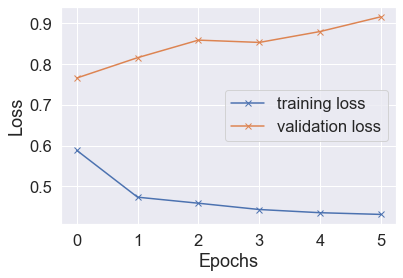

Validation loss: 0.77


In [414]:
# Plot training loss and validation loss for best MLP model
training_loss = best_mlp.history[:, 'train_loss']
validation_loss = best_mlp.history[:, 'valid_loss']

plt.plot(training_loss, 'x-', label='training loss')
plt.plot(validation_loss, 'x-', label='validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

print('Validation loss: %.02f'%min(validation_loss))

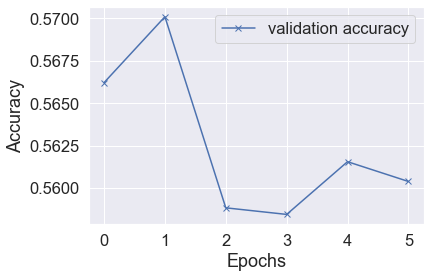

Maximum accuracy: 0.57


In [415]:
# Plot accuracy on validation data on MLP model
validation_accuracy = best_mlp.history[:,'valid_acc']

plt.plot(validation_accuracy,'x-', label='validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

print('Maximum accuracy: %.02f'%max(validation_accuracy))

## Model evaluation
The best SVM and MLP models were compared and evaluated based on AUC score and accuracy on the test data, confusion matrices, Receiver Operation Curve (ROC) and Precision-Recall curve.

AUC score is a more appropriate evaluation metric than accuracy here, because AUC score is less sensitive to differences in target class proportions in the training and test sets.

In [424]:
# Fit dummy model to training data
dummy_model.fit(X_train_smote, y_train_smote)

DummyClassifier(random_state=1, strategy='stratified')

### AUC score

In [331]:
# Calculate AUC score on augmented training set for dummy classifier
dummy_pred = dummy_model.predict_proba(X_train_smote)
dummy_auc = roc_auc_score(y_train_smote, dummy_pred[:, 1])
print("AUC score for dummy classifier on augmented training data: %.3f" %dummy_auc)

AUC score for dummy classifier on augmented training data: 0.499


In [332]:
# Calculate AUC score on test set for dummy classifier
dummy_pred = dummy_model.predict_proba(X_test)
dummy_auc = roc_auc_score(y_test, dummy_pred[:, 1])
print("AUC score for dummy classifier on test data: %.3f" %dummy_auc)

AUC score for dummy classifier on test data: 0.517


In [378]:
# Calculate AUC score on training set for best SVM model
best_svm_y_pred = best_svm.predict_proba(X_train_smote)
best_svm_auc = roc_auc_score(y_train_smote, best_svm_y_pred[:, 1])
print("AUC score for best SVM model on augmented training data: %.3f" %best_svm_auc)

AUC score for best SVM model on augmented training data: 0.850


In [379]:
# Calculate AUC score on test set for best SVM model
best_svm_y_pred = best_svm.predict_proba(X_test)
best_svm_auc = roc_auc_score(y_test, best_svm_y_pred[:, 1])
print("AUC score for best SVM model on test data: %.3f" %best_svm_auc)

AUC score for best SVM model on test data: 0.642


In [416]:
# Calculate AUC score on training set for best MLP model
best_mlp_y_pred = best_mlp.predict_proba(X_train_smote)
best_mlp_auc = roc_auc_score(y_train_smote, best_mlp_y_pred[:, 1])
print("AUC score for best MLP model on augmented training data: %.03f" %best_mlp_auc)

AUC score for best MLP model on augmented training data: 0.839


In [417]:
# Calculate AUC score on test set for best MLP model
best_mlp_y_pred = best_mlp.predict_proba(X_test)
best_mlp_auc = roc_auc_score(y_test, best_mlp_y_pred[:, 1])
print("AUC score for best MLP model on test data: %.03f" %best_mlp_auc)

AUC score for best MLP model on test data: 0.597


### Accuracy

In [161]:
# Calculate accuracy on training set for dummy classifier
dummy_y_pred_class = dummy_model.predict(X_train_smote)
dummy_accuracy = accuracy_score(y_train_smote, dummy_y_pred_class)
print("Accuracy for best dummy classifier on augmented training data: %.3f" %dummy_accuracy)

Accuracy for best dummy classifier on augmented training data: 0.499


In [153]:
# Calculate accuracy on test set for dummy classifier
dummy_y_pred_class = dummy_model.predict(X_test)
dummy_accuracy = accuracy_score(y_test, dummy_y_pred_class)
print("Accuracy for best dummy classifier on test data: %.3f" %dummy_accuracy)

Accuracy for best dummy classifier on test data: 0.520


In [380]:
# Calculate accuracy on training set for best SVM model
best_svm_y_pred_class = best_svm.predict(X_train_smote)
best_svm_accuracy = accuracy_score(y_train_smote, best_svm_y_pred_class)
print("Accuracy for best SVM model on augmented training data: %.3f" %best_svm_accuracy)

Accuracy for best SVM model on augmented training data: 0.779


In [381]:
# Calculate accuracy on test set for best SVM model
best_svm_y_pred_class = best_svm.predict(X_test)
best_svm_accuracy = accuracy_score(y_test, best_svm_y_pred_class)
print("Accuracy for best SVM model on test data: %.3f" %best_svm_accuracy)

Accuracy for best SVM model on test data: 0.741


In [418]:
# Calculate accuracy on training set for best MLP model
best_mlp_y_pred_class = best_mlp.predict(X_train_smote)
best_mlp_accuracy = accuracy_score(y_train_smote, best_mlp_y_pred_class)
print("Accuracy for best MLP model on augmented training data: %.03f" %best_mlp_accuracy)

Accuracy for best MLP model on augmented training data: 0.764


In [419]:
# Calculate accuracy on test set for best MLP model
best_mlp_y_pred_class = best_mlp.predict(X_test)
best_mlp_accuracy = accuracy_score(y_test, best_mlp_y_pred_class)
print("Accuracy for best MLP model on test data: %.03f" %best_mlp_accuracy)

Accuracy for best MLP model on test data: 0.759


### Confusion matrices

Normalized confusion matrix
[[0.81789932 0.18210068]
 [0.66123779 0.33876221]]


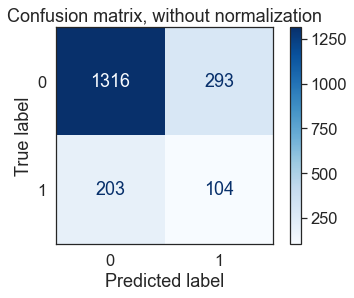

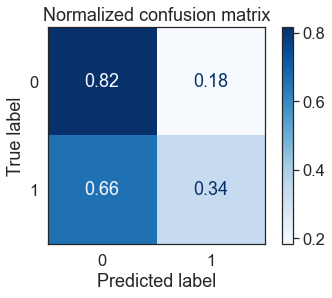

In [382]:
# Display confusion matrix for best SVM model
# Code is from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
sns.set_style('white')

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
  disp = plot_confusion_matrix(best_svm, X_test, y_test,
                               display_labels=data['not.fully.paid'].unique(),
                               cmap=plt.cm.Blues,
                               normalize=normalize)
  disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()
sns.set_style('darkgrid')

Normalized confusion matrix
[[0.85581106 0.14418894]
 [0.74592834 0.25407166]]


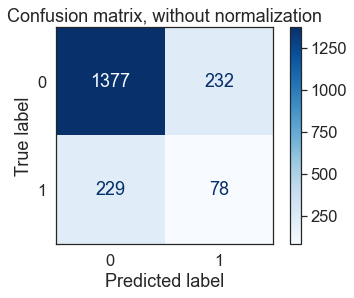

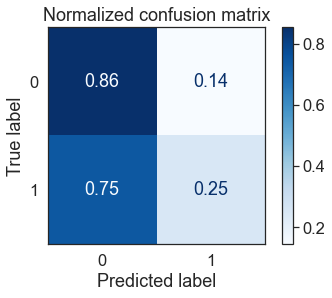

In [420]:
# Display confusion matrix for best MLP model

# Code is from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
sns.set_style('white')
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
  disp = plot_confusion_matrix(best_mlp, X_test, y_test,
                               display_labels=data['not.fully.paid'].unique(),
                               cmap=plt.cm.Blues,
                               normalize=normalize)
  disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()
sns.set_style('darkgrid')


### Receiver Operation Curve (ROC)

In [421]:
# Calculate False Positive Rate (FPR), True Positive Rate (TPR) and threshold for best SVM model
svm_FPR, svm_TPR, svm_thresholds = roc_curve(y_test, best_svm_y_pred_class)

# Calculate the geometric mean for the threshold for best SVM model
svm_gmeans = np.sqrt(svm_TPR * (1-svm_FPR))

# Determine the best FPR and TPR at largest geometric mean for best SVM model
svm_ix = np.argmax(svm_gmeans)
print('Best False Positive Rate=%.3f, Best True Positive Rate = %.3f' %(svm_FPR[svm_ix],svm_TPR[svm_ix]))

Best False Positive Rate=0.182, Best True Positive Rate = 0.339


In [422]:
# Calculate False Positive Rate (FPR), True Positive Rate (TPR) and threshold for best MLP model
mlp_FPR, mlp_TPR, mlp_thresholds = roc_curve(y_test, best_mlp_y_pred_class)

# Calculate the geometric mean for the threshold for best MLP model
mlp_gmeans = np.sqrt(mlp_TPR * (1-mlp_FPR))

# Determine the best FPR and TPR at largest geometric mean for best MLP model
mlp_ix = np.argmax(mlp_gmeans)
print('Best False Positive Rate=%.3f, Best True Positive Rate = %.3f' %(mlp_FPR[mlp_ix],mlp_TPR[mlp_ix]))

Best False Positive Rate=0.144, Best True Positive Rate = 0.254


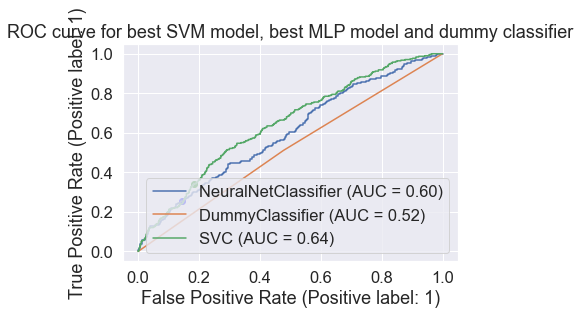

In [425]:
# Plot Receiver Operation Curve (ROC) for best MLP model 
best_mlp_roc = plot_roc_curve(best_mlp, X_test, y_test)

# Add ROC for Dummy Classifier model
dummy_roc = plot_roc_curve(dummy_model, X_test, y_test, ax=best_mlp_roc.ax_)

# Add ROC for best SVM model 
best_svm_roc = plot_roc_curve(best_svm, X_test, y_test, ax=best_mlp_roc.ax_)

# Add optimal threshold for best MLP model
plt.scatter(mlp_FPR[mlp_ix], mlp_TPR[mlp_ix], marker='o', color='blue')

# Add optimal threshold for best SVM model
plt.scatter(svm_FPR[svm_ix], svm_TPR[svm_ix], marker='o', color='green')

# Add title
plt.title("ROC curve for best SVM model, best MLP model and dummy classifier")
plt.show()

### Precision-recall curve

In [426]:
# Obtain precision, recall and threshold for best SVM model
svm_precision, svm_recall, svm_prthresholds = precision_recall_curve(y_test, best_svm_y_pred_class)

# Calculate F1 score for the best SVM model
svm_fscore = (2 * svm_precision * svm_recall) / (svm_precision + svm_recall)

# Determine the best recall and precision at largest F1 score for best MLP model
svmf_ix = np.argmax(svm_fscore)
print('Best Recall=%.3f, Best Precision=%.3f' % (svm_recall[svmf_ix],svm_precision[svmf_ix]))

Best Recall=0.339, Best Precision=0.262


In [427]:
# Obtain precision, recall and threshold for best MLP model
mlp_precision, mlp_recall, mlp_prthresholds = precision_recall_curve(y_test, best_mlp_y_pred_class)

# Calculate F1 score for best MLP model
mlp_fscore = (2 * mlp_precision * mlp_recall) / (mlp_precision + mlp_recall)

# Determine the best recall and precision at largest F1 score for best MLP model
mlpf_ix = np.argmax(mlp_fscore)
print('Best Recall=%.3f, Best Precision=%.3f' % (mlp_recall[mlpf_ix],mlp_precision[mlpf_ix]))

Best Recall=1.000, Best Precision=0.160


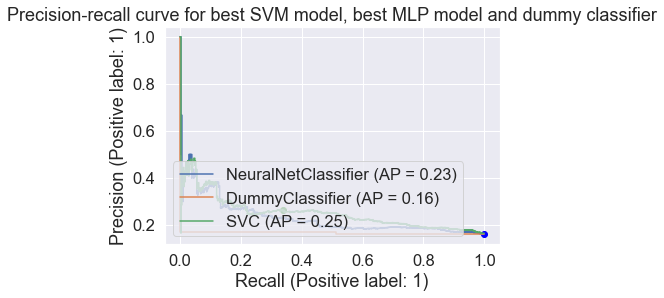

In [428]:
# Plot Precision-Recall Curve for best MLP model
best_mlp_prc = plot_precision_recall_curve(best_mlp, X_test, y_test)

# Add Precision-Recall Curve for Dummy Classifier model
dummy_prc = plot_precision_recall_curve(dummy_model, X_test, y_test, ax=best_mlp_prc.ax_)

# Add Precision-Recall Curve for best SVM model 
best_svm_prc = plot_precision_recall_curve(best_svm, X_test, y_test, ax=best_mlp_prc.ax_)

# Add optimal threshold for best SMV model
plt.scatter(svm_recall[svmf_ix], svm_precision[svmf_ix], marker='o', color='green')

# Add optimal threshold for best MLP model
plt.scatter(mlp_recall[mlpf_ix], mlp_precision[mlpf_ix], marker='o', color='blue')

# Add title
plt.title("Precision-recall curve for best SVM model, best MLP model and dummy classifier")
plt.show()

## Conclusion
Both MLP and SVM models exhibited good capability (higher than stratified random guessing) in differentiating borrrowers who would pay back the loan in full or not. The optimal SVM model was slightly better than the MLP model based on the AUC score. The higher sensitivity of SVM (34%) compared to MLP (25%) also suggested the SVM model was more suitable for this task, where a high cost was associated with incorrect classification of borrowers who did not pay back the loan in full. There were, however, small trade-offs in specificity. Further investigation should be made into developing other models, such as bagging ensemble models, as such models may provide lower variance and higher generalizability.